In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib.collections import LineCollection
import numba
from matplotlib import colors as mcolors
import pandas as pd
from itertools import combinations

import matplotlib.pyplot as plt; plt.rcdefaults()
from scipy import stats
import matplotlib.mlab as mlab
import math

In [21]:
# ***** To Do: write the location of locust_posture_data.h5 *****
posture_data_location = 'locust_posture_data.h5'

In [22]:
body_parts = pd.read_csv('skeleton.csv').values
skeleton = np.load('locust_skeleton.npy')

In [23]:
def get_data(frame, skeleton):
    """ Export data from h5 file: 'locust_posture_data.h5'
    
    Parameters
    ----------
    frame : int
        Frame number of which data will be exported from

    skeleton : array-like
        Array containing x,y coordinates, shape: (35, 2)
    
    Returns
    -------
    allLocusts : list, 
        List of line segments that make up each individual 
        locust, shape: (103, 26, 2, 2)
    
    totalIndividuals: int
        Number of total locusts in the posture data 
    """
    with h5py.File(posture_data_location) as h5file:
        compressed = h5file['joints'][:,frame,...,:2]

    N_INDIVID = len(compressed)
    allLocusts = [] # empty list. fill this will all individual's line segment stacks

    for individ in range(N_INDIVID):
        line_segments = [] # empty list
        for idx, jdx in enumerate(skeleton[:,0]):
            if jdx != -1: # if node has parent... 
                line_segments.append(compressed[individ][[idx,jdx]])
        allLocusts.append(np.stack(line_segments))  
        # shape of line_segments (26, 2, 2)
        # shape of allLocusts (103, 26, 2, 2)
        totalIndividuals = len(line_segments)
    return allLocusts, totalIndividuals

In [5]:
@numba.njit(fastmath=True)
def det(a, b, c, d):    
    return a*d - b*c

@numba.njit(fastmath=True)
def line_line_intersection(a, b):
    
    intersects = False
    intersection = np.empty((1,2))+np.nan

    x1 = a[0,0]
    x2 = a[1,0]
    y1 = a[0,1]
    y2 = a[1,1]
    
    x3 = b[0,0]
    x4 = b[1,0]
    y3 = b[0,1]
    y4 = b[1,1]
    
    dxa = x1 - x2
    dxb = x3 - x4
        
    dya = y1 - y2
    dyb = y3 - y4
    
    denominator = det(dxa, dya, dxb, dyb)
    parallel = denominator == 0
    
    if not parallel:
        
        dyab = y4 - y1
        dxab = x4 - x1
        lamda = ((-dyb) * (dxab) + (dxb) * (dyab)) / denominator
        gamma = ((dya) * (dxab) + (-dxa) * (dyab)) / denominator
        intersects = (0 < lamda < 1) & (0 < gamma < 1)
        
        ''' # previous method of checking endpoint intersecting limb
        dxc = x1 - x3
        dyc = y1 - y3

        dxl = x4 - x1
        dyl = y4 - y3

        # check if point is on the line
        cross = dxc * dyl - dyc * dxl
            
        if cross == 0: # point is on line. count this as an intersection
            intersects = True
        
        # new method of checking endpoint intersecting limb
        if not intersects: # check if limb of locustA contains point of limbB
            # check overlap
            intersects, intersection = check_all_overlap(x1, y1, x2, y2, x3, y3, x4, y4)       
        if intersects: # calculate point of intersection

            det_a = det(x1, y1, x2, y2)
            det_c = det(x3, y3, x4, y4)

            x = det(det_a, dxa, det_c, dxb) / denominator

            y = det(det_a, dya, det_c, dyb) / denominator

            intersection[0,0] = x
            intersection[0,1] = y
    '''
    return intersects, intersection

@numba.njit(fastmath=True)
def get_intersection_matrix(line_segments_A, line_segments_B):  
    """ Get intersection matrix between locust A and B
    
    Parameters
    ----------
    line_segments_A : {array-like, sparse matrix}, shape (26, 2, 2)
        Line segments of locust A
        
    line_segments_B : {array-like, sparse matrix}, shape (26, 2, 2)
        Line segments of locust B
    
    Returns
    -------
    intersection_matrix : {array-like, sparse matrix}, shape (26, 26)
        Intersection matrix between Locust A's 26 limbs and B's 26 limbs
    
    """
    intersection_matrix = np.zeros((26, 26))
    for Adx in range(len(line_segments_A)):
        jointA  = line_segments_A[Adx] # for each joint in locust A
        for Bdx in range(len(line_segments_B)):
            jointB = line_segments_B[Bdx] # for each joint in Locust B
            if (line_line_intersection(jointA, jointB)[0]): # if there is an intersection between joints
                intersection_matrix[Adx, Bdx]=1
                break
    return intersection_matrix

In [6]:
@numba.njit(parallel=True)
def get_adjmatrix(N_INDIVID, N_SEGMENTS, allLocusts):
    """ Get an large  intersection matrix of size (N_INDIVID, N_INDIVID, N_SEGMENTS, N_SEGMENTS) 
    
    Parameters
    ----------
    N_INDIVID: int
        Number of individual locusts (103)
    N_SEGMENTS: int
        Number of line segments that make up locusts body (26)
    allLocusts : list , shape: (26, 2, 2)
        contains the line segments that make up the joints of all the locusts
       
        
    Returns
    -------
    adj_matrix : {array-like, sparse matrix}, shape (103, 103, 26, 26)
       
    """
    adj_matrix = np.zeros((N_INDIVID, N_INDIVID, N_SEGMENTS, N_SEGMENTS))
    for locustA in numba.prange(N_INDIVID):
    # for locustA in range(N_INDIVID):
        # for locustB in range(N_INDIVID):
        for locustB in numba.prange(N_INDIVID):
            if (locustA != locustB): # only the interaction matrix of locust interacting with other individuals
                intersection = get_intersection_matrix(allLocusts[locustA], allLocusts[locustB])
                adj_matrix[locustA, locustB, :, :] = intersection  
    return adj_matrix

In [7]:
def bounding_box(line_segs):
    min_x, min_y = np.min(line_segs, axis=0)
    max_x, max_y = np.max(line_segs, axis=0)
    return np.array([(min_x, max_x), (min_y, max_y)])
    # return np.array([(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y), (min_x, min_y)])

In [8]:
# https://stackoverflow.com/questions/20925818/algorithm-to-check-if-two-boxes-overlap
def overlapping1D(line1, line2):
    min1, max1 = line1[0], line1[1]
    min2, max2 = line2[0], line2[1]
    return (max1>=min2 and max2>=min1)
    
def bounding_box_overlap(box1, box2):
    in_xrange = overlapping1D(box1[0,:], box2[0,:]) # x 
    in_yrange = overlapping1D(box1[1,:], box2[1,:]) # y
    return (in_xrange and in_yrange)

In [9]:
def get_pairwise(init_frame, time_window):
        
    """ Get Time Series Data with shape (N_INDIVID, time_window, segments, segments)
            touching : boolean
                in x frames back, is LocustA touching LocustB?
    
    Parameters
    ----------
    init_frame: int
        Initial frame
    time_window: int
        How many frames are you going back
       
        
    Returns
    -------
    TS_data : {array-like, sparse matrix}, shape (103, time_window, 26, 26)
        Obtain time series data 
       
    """
    
    TS_data = np.zeros((103, time_window, 26, 26))
    ts_count = 0
    
    # Calculate Bounding Boxes
    for frame in range(init_frame - time_window + 1, init_frame + 1): # ex: frame 5-10 (inclusive)
        print("frame", frame)
        bounding_boxes=[]
        # allLocusts = data of locust joints # N_SEGMENTS = 26 
        allLocusts, N_SEGMENTS = get_data(frame = frame, skeleton = skeleton) 
        
        # compute adjacency matrix (26, 26) with 0/1 for touching by checking overlapping bounding boxes
        
        # compute bounding boxes for all
        for locust in range(103):
            bounding_boxes.append(bounding_box(allLocusts[locust].reshape(52, 2)))

        for locustA, locustB in combinations(range(103), 2):  
            # if bounding boxes intersect
            if bounding_box_overlap(bounding_boxes[locustA], bounding_boxes[locustB]):
                # get intersection matrix where rows represent LocustA limbs and cols represent locustB limbs
                intersection_matrix=get_intersection_matrix(allLocusts[locustA], allLocusts[locustB])
                TS_data[locustA, ts_count, :, :]=TS_data[locustA, ts_count, :, :]+intersection_matrix

                # transpose intersection matrix so rows are now locustB's limbs
                TS_data[locustB, ts_count, :, :]+=np.transpose(intersection_matrix)
                
        ts_count += 1
    return TS_data

In [10]:
'''batch = get_pairwise(int(2*totalFrames/10)-2, int(totalFrames/10))
with h5py.File('26x26_batch02.h5', 'w') as h5File:
    h5File.create_dataset('batch2', data=batch)'''

"batch = get_pairwise(int(2*totalFrames/10)-2, int(totalFrames/10))\nwith h5py.File('26x26_batch02.h5', 'w') as h5File:\n    h5File.create_dataset('batch2', data=batch)"

### Get Data
Split into 10 batches

In [6]:
totalFrames=324299
# totalFrames=48 # for testing

In [22]:
n_time=totalFrames
with h5py.File('delete_this.h5', 'w') as h5File:
    h5File.create_dataset('delete', shape=(103, n_time, 26, 26), dtype=np.uint8)

In [23]:
# get_pairwise(int(totalFrames/10)-2, int(totalFrames/10))

for time in range(100, n_time, 100):
    with h5py.File('delete_this.h5', mode='r+') as h5file:
        calculated_data = get_pairwise(time-1, 100) # this is where you’d run get_pairwise
        h5file['delete'][:, time-100:time] = calculated_data.astype(np.uint8)

frame 0
frame 1
frame 2
frame 3
frame 4
frame 5
frame 6
frame 7
frame 8
frame 9
frame 10
frame 11
frame 12
frame 13
frame 14
frame 15
frame 16
frame 17
frame 18
frame 19
frame 20
frame 21
frame 22
frame 23
frame 24
frame 25
frame 26
frame 27
frame 28
frame 29
frame 30
frame 31
frame 32
frame 33
frame 34
frame 35
frame 36
frame 37
frame 38
frame 39
frame 40
frame 41
frame 42
frame 43
frame 44
frame 45
frame 46
frame 47
frame 48
frame 49
frame 50
frame 51
frame 52
frame 53
frame 54
frame 55
frame 56
frame 57
frame 58
frame 59
frame 60
frame 61
frame 62
frame 63
frame 64
frame 65
frame 66
frame 67
frame 68
frame 69
frame 70
frame 71
frame 72
frame 73
frame 74
frame 75
frame 76
frame 77
frame 78
frame 79
frame 80
frame 81
frame 82
frame 83
frame 84
frame 85
frame 86
frame 87
frame 88
frame 89
frame 90
frame 91
frame 92
frame 93
frame 94
frame 95
frame 96
frame 97
frame 98
frame 99
frame 100
frame 101
frame 102
frame 103
frame 104
frame 105
frame 106
frame 107
frame 108
frame 109
frame 110


In [42]:
with h5py.File('delete_this.h5', mode='r+') as h5file:
    calculated_data = get_pairwise(899, 100) # this is where you’d run get_pairwise
    h5file['delete'][:, time-100:time] = calculated_data.astype(np.uint8)

frame 800
frame 801
frame 802
frame 803
frame 804
frame 805
frame 806
frame 807
frame 808
frame 809
frame 810
frame 811
frame 812
frame 813
frame 814
frame 815
frame 816
frame 817
frame 818
frame 819
frame 820
frame 821
frame 822
frame 823
frame 824
frame 825
frame 826
frame 827
frame 828
frame 829
frame 830
frame 831
frame 832
frame 833
frame 834
frame 835
frame 836
frame 837
frame 838
frame 839
frame 840
frame 841
frame 842
frame 843
frame 844
frame 845
frame 846
frame 847
frame 848
frame 849
frame 850
frame 851
frame 852
frame 853
frame 854
frame 855
frame 856
frame 857
frame 858
frame 859
frame 860
frame 861
frame 862
frame 863
frame 864
frame 865
frame 866
frame 867
frame 868
frame 869
frame 870
frame 871
frame 872
frame 873
frame 874
frame 875
frame 876
frame 877
frame 878
frame 879
frame 880
frame 881
frame 882
frame 883
frame 884
frame 885
frame 886
frame 887
frame 888
frame 889
frame 890
frame 891
frame 892
frame 893
frame 894
frame 895
frame 896
frame 897
frame 898
frame 899


In [24]:
'''# testing
totalFrames=6000
batch = get_pairwise(totalFrames-1, totalFrames)'''

'# testing\ntotalFrames=6000\nbatch = get_pairwise(totalFrames-1, totalFrames)'

### Get Y Data: Movement Classification

In [7]:
with h5py.File('moving_classification_og_head.h5', 'r') as h5File:
    moving_classification_h5 = h5File.get('moving_classification')
    moving_classification = np.array(moving_classification_h5)
moving_classification.shape

(103, 324399)

In [8]:
def get_TS_movement(moving_classification, init_frame, time_window):
    """ Get Time Series Movement Classification Data 
            time_window : how many frames you go back
            
    Parameters
    ----------
    moving_classification : {array-like, sparse matrix}, shape = (103, 108133)
        0/1: Is locust moving (1) or paused (0)? 
    init_frame: int
        Initial frame
    time_window: int
        How many frames are you going back
       
        
    Returns
    -------
    TS_data : {array-like, sparse matrix}, shape (N_INDIVID, time_window, 
                                                    movement_classification)
        Obtain time series data (Dependent variable, predictor)
    """
    TS_data = np.zeros((103, time_window, 1))
    skeleton = np.load('locust_skeleton.npy')
    ts_count = 0
    for frame in range(init_frame - time_window + 1, init_frame + 1): # ex: frame 5-10 (inclusive)
        #get movement classification
        for LocustA in range(103):
            TS_data[LocustA, ts_count, 0] = moving_classification[LocustA][frame]
        ts_count += 1
    return TS_data

In [9]:
y = get_TS_movement(moving_classification, totalFrames-1, totalFrames)

In [10]:
with h5py.File('all_movement.h5', 'w') as h5File:
    h5File.create_dataset('y', data=y)

In [11]:
y=y[:, 0:totalFrames, :]

In [12]:
# ((103, totalFrames, 26, 26), (103, totalFrames, 1))
y.shape 

(103, 324299, 1)

### Data Analysis

#### Functions

In [27]:
def classification(classification):
    """ fill array: newX, to determine if the locust is touching the front/back, left/right. 
            
    Parameters
    ----------
    classification : array, shape = (26, )
        Number to classify the part of the body of the locust
    X : {array-like, sparse matrix}  shape (N_INDIVID, time_window, 
                                            movement_classification)
       
        
    Returns
    -------
    TS_data : {array-like, sparse matrix}, shape (N_INDIVID, time_window, 
                                                    movement_classification)
        Obtain time series data (Dependent variable, predictor)
    """
    
    
    template=np.zeros((103,totalFrames,1))
    newX=np.full_like(template, np.nan)

    # count = np.zeros((4))
    limb_count = np.zeros((len(body_parts)))

    for locust in range(103):
        print(locust)
        for frame in range(totalFrames):
            # print(frame)
            
            with h5py.File('test.h5', mode='r+') as h5file:
                X = h5file['test'][locust, frame, :, :] # shape: (26, 26)

            X=np.sum(X, axis=1)
            interaction = np.sum(X)
            
            if (interaction>1): # touching multiple limbs
                index = np.array(X.nonzero())[0] # get index to identify the limb

                classification_sum=0
                for idx in index:
                    if (not np.isnan(classification[idx])):
                        # count[int(classification[idx])]+=1
                        limb_count[idx]+=1
                        classification_sum+=classification[idx]
                avg_classification=classification_sum/index.shape[0]
                if avg_classification==0: # if all the limbs are touching front, record as front
                    newX[locust, frame, 0] = 0
                elif avg_classification==1: # if all the limbs are touching back, record as back
                    newX[locust, frame, 0] = 1
                elif avg_classification==5: # if all the limbs are touching back, record as back
                    newX[locust, frame, 0] = 5
                elif avg_classification==31: # if all the limbs are touching back, record as back
                    newX[locust, frame, 0] = 31
                # else: if touching on front and back, keep newX value as np.nan

            if (interaction==1): # touching *one* other limb
                index = np.nonzero(X) # get index to identify the limb
                if (not np.isnan(classification[index][0])):
                    newX[locust, frame, 0] = classification[index][0] # get classification
                    # count[int(classification[index][0])]+=1
                    limb_count[index]+=1

    return newX, limb_count #, count

In [ ]:
def get_past(individ, frame, framesback, newX, zero, one, five, threeone):
    # get array of past X frames
    for frameback in range(framesback):
        if newX[individ, frame-frameback]==0: 
            zero[frameback]+=1
        if newX[individ, frame-frameback]==1: 
            one[frameback]+=1
        if newX[individ, frame-frameback]==5: 
            five[frameback]+=1
        if newX[individ, frame-frameback]==31: 
            threeone[frameback]+=1
    return zero, one, five, threeone
    
def history(newX, framesback, region, want_PL_or_Greater, pause_length, filter_frames=0):
    zero=np.zeros(framesback)
    one=np.zeros(framesback)
    five=np.zeros(framesback)
    threeone=np.zeros(framesback) 
                    
    speed_changes = 0
    for individ in range(y.shape[0]):
        print(individ)
        for frame in range(framesback, y.shape[1]-filter_frames):
            
            if filter_frames>0: #  Filtering out the brief changes in motion 
                past, future=0,0
                for numb in range(filter_frames):
                    past+=y[individ, frame-(numb+1)]
                    future+=y[individ, frame+numb]
                # Keep data points where locust was paused for X frames, moving for X frames
                if (future-past)==filter_frames:
                    speed_changes+=1
                    zero, one, five, threeone=get_past(individ, frame, framesback, newX, zero, one, five, threeone) # count 
                    
            elif filter_frames==0: # no filtering
                past=0
                for prev in range(pause_length):
                    past += y[individ, frame-(prev+1)] # 0
                if want_PL_or_Greater: # if the locust has a consecutive pause of length X or greater 
                    if past==0:
                        if (y[individ, frame] - y[individ, frame-1])==1: 
                            speed_changes+=1
                            zero, one, five, threeone=get_past(individ, frame, framesback, newX, zero, one, five, threeone) # count 
                # if the locust has a consecutive pause of length and in the frame before the pause length, it was moving. Only counting interactions of pause length = 1 (no others!)
                else: 
                    if past==0 and y[individ, frame-(pause_length+1)]==1:
                        if (y[individ, frame] - y[individ, frame-1])==1: 
                            speed_changes+=1
                            zero, one, five, threeone=get_past(individ, frame, framesback, newX, zero, one, five, threeone) # count 
                                    
    if (region=='FB' or region=='LR'): # FB and LR only have 0 and 1 as classification numbers 
        print("speed changes: ", speed_changes)
        plot_two(zero/speed_changes, one/speed_changes, framesback, region, want_PL_or_Greater, filter_frames, pause_length)

    if region=='AFMB': # AFMB has 0, 1, 5, 31 as classification numbers
        ant, front, middle, back, = zero/speed_changes, one/speed_changes, five/speed_changes, threeone/speed_changes
        print("speed changes: ", speed_changes)
        plot_AFMB(ant, front, middle, back, framesback, region, want_PL_or_Greater, filter_frames, pause_length)

In [14]:
colors = ['dodgerblue', 'orange', 'g', 'r']

In [15]:
def plot_AFMB(ant, front, middle, back, framesback, region, want_PL_or_Greater, filter_frames, pause_length):

    labels=["Antenna", "Front", "Middle", "Back"]
    ind = np.arange(framesback)  # the x locations for the groups
    fig, ax = plt.subplots()

    ant_line, = plt.plot(ind, ant, label="P(%s)" % labels[0], linestyle=':')
    front_line, = plt.plot(ind, front, label="P(%s)" % labels[1], linestyle=':')
    middle_line, = plt.plot(ind, middle, label="P(%s)" % labels[2], linestyle=':')
    back_line, = plt.plot(ind, back, label="P(%s)" % labels[3], linestyle=':')
    
    # avg line
    for idx, avg in enumerate(avg_AFMB):
        plt.axhline(y=avg, linestyle='-', color=colors[idx])

    plt.legend(bbox_to_anchor=(1, 1), loc=1, fontsize=20)
    
    ax.set_xlabel('Number of frames back in time', fontsize=20)
    ax.set_ylabel('P(Interaction with Limb)', fontsize=20)
    
    ax.set_xticks(np.arange(0, framesback, 10))
    ax.set_xticklabels(np.arange(0, framesback, 10))
    fig.set_size_inches((30, 12))

    if filter_frames>0: 
        ax.set_title('Probability Locusts Touches with Limb in the Previous %d Frames Before a Change From a %d Length Pause to %d Length Moving is Observed' % (framesback, filter_frames, filter_frames), fontsize=25)
    else: 
        ax.set_title('Probability Locusts Touches with Limb in the Previous %d Frames Before a Change From a %d Length Pause to Moving is Observed' % (framesback, pause_length), fontsize=25)

    if filter_frames>0: 
        fig.savefig('./plots/AFMB/AFMB_filter%d.png' % filter_frames) 
    elif want_PL_or_Greater: 
        fig.savefig('./plots/AFMB/AFMB_%d_or_more.png' % pause_length)
    else: 
        fig.savefig('./plots/AFMB/AFMB_only%d.png' % pause_length)
    
    plt.show()

In [16]:
def plot_two(front, back, framesback, region, want_PL_or_Greater, filter_frames, pause_length):
    ind = np.arange(framesback) # the x locations for the groups
    if region=='FB': 
        labels = ['Front', 'Back']
    elif region=='LR':
        labels = ['Left', 'Right']

    fig, ax = plt.subplots()
    
    plt.plot(ind, front, label=labels[0], linestyle=':')
    plt.plot(ind, back, label=labels[1], linestyle=':')
    
    #plot avg line
    for idx, avg in enumerate(avg_two):
        plt.axhline(y=avg, linestyle='-', color=colors[idx])

    plt.legend(bbox_to_anchor=(1, 1), loc=1)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Number of frames back in time')
    ax.set_ylabel('P(Interaction with Limb)')
    
    if filter_frames>0: 
        ax.set_title('Probability Locusts Touches with Limb in the Previous %d Frames \n Before a Change From a %d Length Pause to %d Length Moving is Observed' % (framesback, filter_frames, filter_frames))
    else: 
        ax.set_title('Probability Locusts Touches with Limb in the Previous %d Frames \n Before a Change From a %d Length Pause to Moving is Observed' % (framesback, pause_length))

    ax.set_xticks(np.arange(0, framesback, 10))
    ax.set_xticklabels(np.arange(0, framesback, 10))
    if filter_frames>0: 
        fig.savefig('./plots/%s/%s_filter%d.png' % (region, region, filter_frames))
    elif want_PL_or_Greater: 
        fig.savefig('./plots/%s/%s_%d_or_more.png' % (region, region, pause_length))
    else: 
        fig.savefig('./plots/%s/%s_only%d.png' % (region, region, pause_length))
    plt.show()

Limb Interaction Heatmap 

In [17]:
def heatmap(limb_count):
    with h5py.File('Locust_Template.h5', 'r') as h5File:
        allLocusts = h5File.get('allLocusts')
        allLocusts = np.array(allLocusts)

    N_INDIVID = len(allLocusts)
    fig = plt.figure(figsize=(5,10))
    ax = plt.gca()
    # for limb 
    for limb in range(np.array(allLocusts).shape[1]):
        i=limb+1
        if i==26:
            line_collection = LineCollection((allLocusts[0][limb], allLocusts[1][0]), colors=plt.cm.gist_heat(limb_count[limb]/np.max(limb_count)), cmap='copper')
        else:
            line_collection = LineCollection((allLocusts[0][limb], allLocusts[0][i]), colors=plt.cm.gist_heat(limb_count[limb]/np.max(limb_count)), cmap='copper')
        ax.add_collection(line_collection)

    plt.xlim(970,1040)
    plt.ylim(1425,1510)
    fig.savefig('./plots/%s/%s_heatmap.png' % (region, region))
    plt.show()

### Individual Locust's Limb Interactions

#### Data Preprocessing

In [18]:
# given the body_parts array, classify the body parts as FB/LR (based on the list of body parts)
# 0: front, 1: back
classification_fb=np.array([0,0,1,1,0,0,0,0,0,np.nan,np.nan,np.nan,1,1,1,0,0,0,0,0,np.nan,np.nan,np.nan,1,1,1])

# 0: left, 1: right
classification_lr=np.array([np.nan,np.nan,np.nan,np.nan,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1])

# antennae=0; front=1; middle=5; back=31
classification_AFMB=np.array([np.nan,np.nan,np.nan,np.nan,0,0,1,1,1,5,5,5,31,31,31,0,0,1,1,1,5,5,5,31,31,31])
ant_numb, front_numb, mid_numb, back_numb = 0, 1, 5, 31

In [25]:
'''# X_26: ([103, totalFrames, 26])
X_26=np.sum(X, axis=3)
X_26.shape'''

'# X_26: ([103, totalFrames, 26])\nX_26=np.sum(X, axis=3)\nX_26.shape'

#### Plots
Plots saved under ./plots/

In [26]:
! mkdir plots
! mkdir plots\pairwise
! mkdir plots\FB
! mkdir plots\AFMB
! mkdir plots\LR
! mkdir plots\FL_Speed

A subdirectory or file plots already exists.
A subdirectory or file plots\pairwise already exists.
A subdirectory or file plots\FB already exists.
A subdirectory or file plots\AFMB already exists.
A subdirectory or file plots\LR already exists.
A subdirectory or file plots\FL_Speed already exists.


In [19]:
# Alter the Pause_Length
pause_lengths = [1, 3, 9, 18]
framesback=270 # ** Change?

AFMB: Antennae, Front, Middle, Back

In [ ]:
X_AFMB, limb_count = classification(classification_AFMB)

In [ ]:
unique, counts = np.unique(X_AFMB, return_counts=True)
print("unique: ", unique[0:4], " counts: ", counts[0:4])

avg_AFMB=np.array([counts[0]/(totalFrames*103), counts[1]/(totalFrames*103), counts[2]/(totalFrames*103), counts[3]/(totalFrames*103)])  

In [ ]:
region = 'AFMB'

# get history of interaction where you include the paused length or greater
for pause_length in pause_lengths:
    history(X_AFMB, framesback, region, want_PL_or_Greater=True, pause_length=pause_length)

# get history of only instances with a paused length of x
for pause_length in pause_lengths:
    history(X_AFMB, framesback, region, want_PL_or_Greater=False, pause_length=pause_length)


# filter out the brief changes in motion, Keep data points where locust was paused for X frames, moving for X frames
filter_frames = 3
history(X_AFMB, framesback, region, want_PL_or_Greater=False, pause_length=np.nan, filter_frames=filter_frames)

# create heatmap of most frequent interactions per limb
heatmap(limb_count)

FB: Front, Back

In [ ]:
region = 'FB'
X_FB, limb_count = classification(classification_fb)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
with h5py.File('X_FB.h5', mode='w') as h5file:
    h5file.create_dataset('X_FB', data=X_FB, shape=X_FB.shape, dtype=np.uint8)

In [155]:
unique, counts = np.unique(X_FB, return_counts=True)
print("unique: ", unique[0:2], " counts: ", counts[0:2])

avg_two=np.array([counts[0]/(totalFrames*103), counts[1]/(totalFrames*103)])

unique:  [0. 1.]  counts:  [10419  2607]


speed changes:  2687


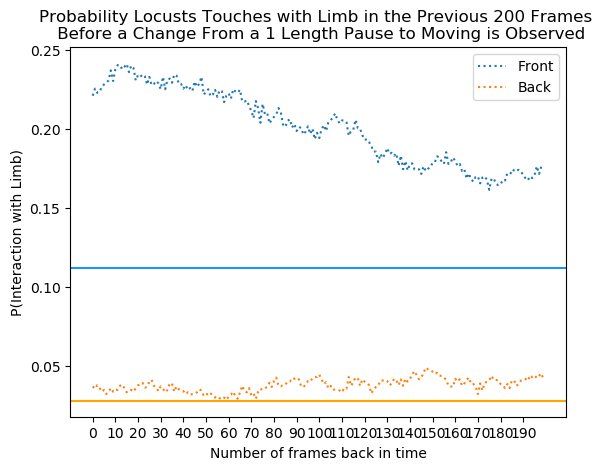

speed changes:  1046


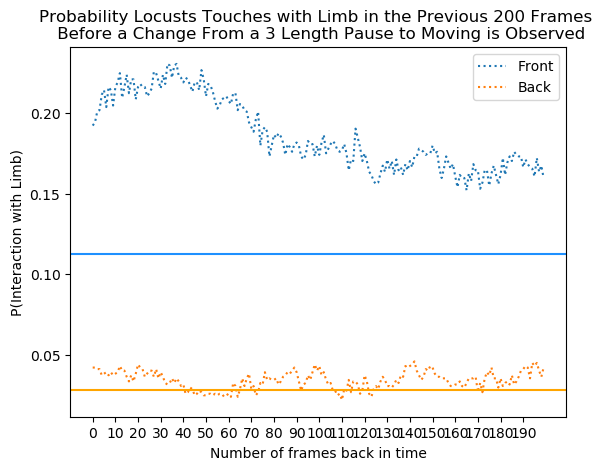

speed changes:  467


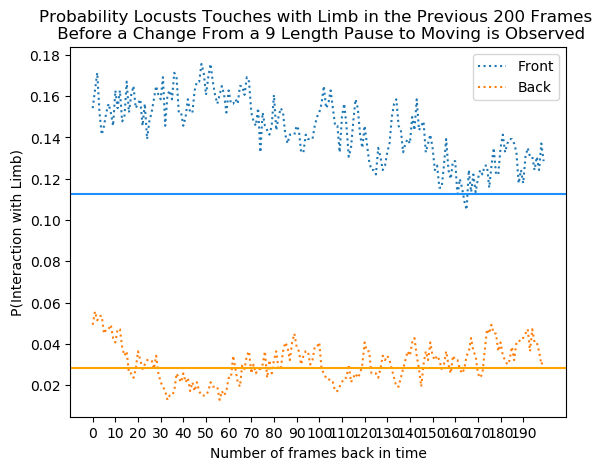

speed changes:  274


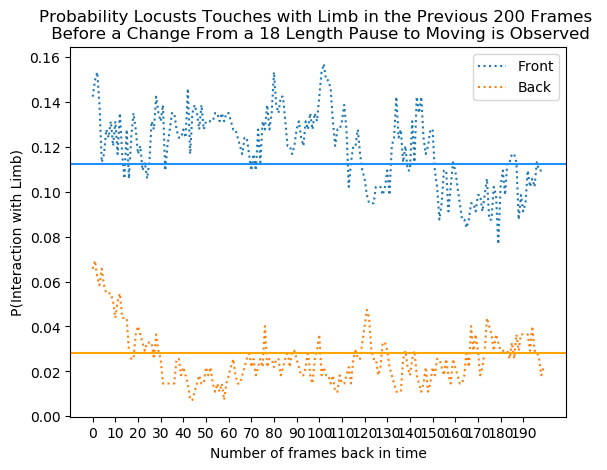

speed changes:  1231


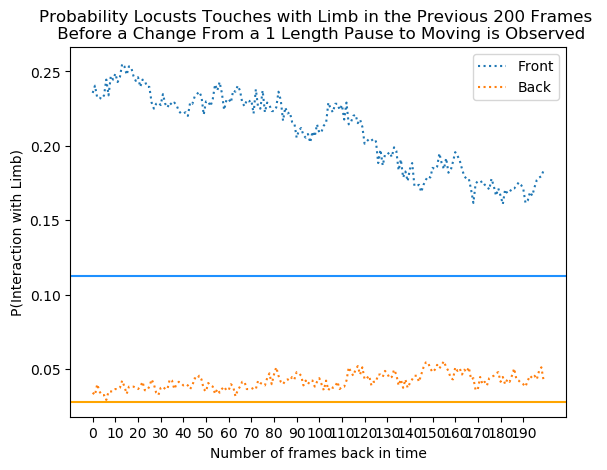

speed changes:  220


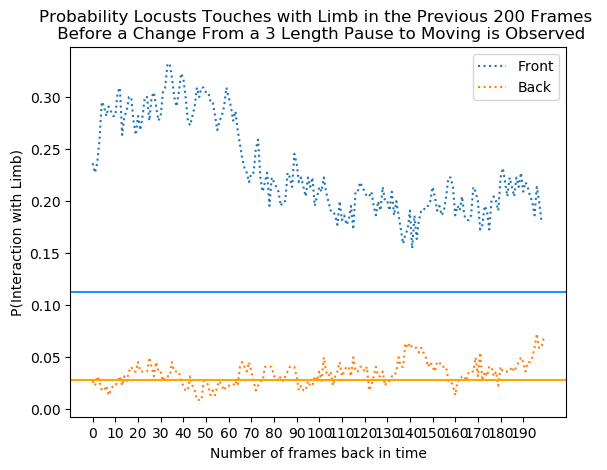

speed changes:  44


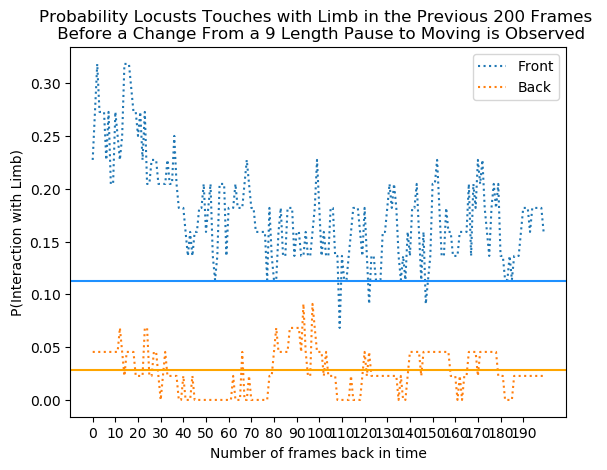

speed changes:  12


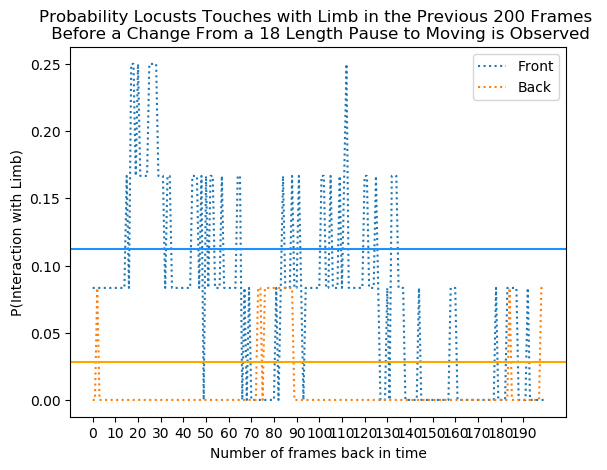

speed changes:  329


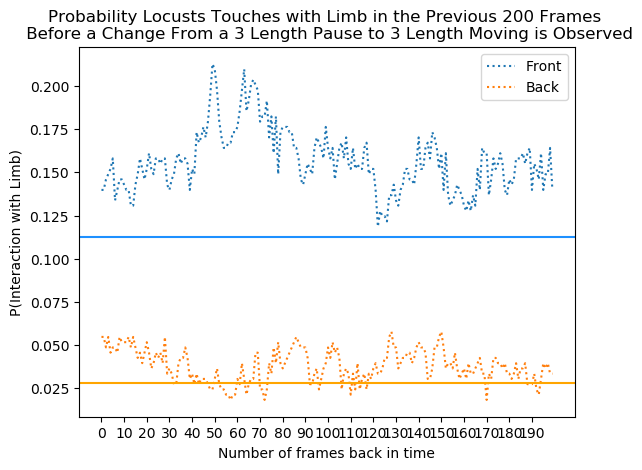

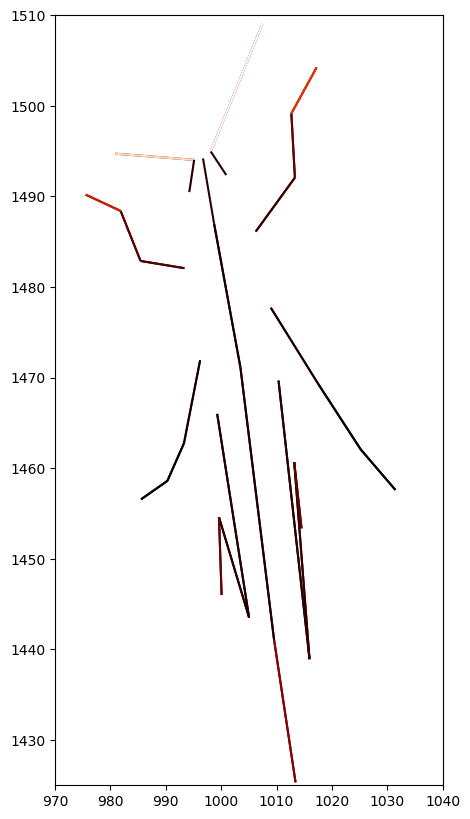

In [128]:
# get history of interaction where you include the paused length or greater
for pause_length in pause_lengths:
    history(X_FB, framesback, region, want_PL_or_Greater=True, pause_length=pause_length)

# get history of only instances with a paused length of x
for pause_length in pause_lengths:
    history(X_FB, framesback, region, want_PL_or_Greater=False, pause_length=pause_length)


# filter out the brief changes in motion, Keep data points where locust was paused for X frames, moving for X frames
filter_frames = 3
history(X_FB, framesback, region, want_PL_or_Greater=False, pause_length=np.nan, filter_frames=filter_frames)

# create heatmap of most frequent interactions per limb
heatmap(limb_count)

LR: Left/Right

In [98]:
region = 'LR'
X_LR, limb_count = classification(classification_lr)

In [156]:
unique, counts = np.unique(X_LR, return_counts=True)
print("unique: ", unique[0:2], " counts: ", counts[0:2])

avg_two=np.array([counts[0]/(totalFrames*103), counts[1]/(totalFrames*103)])

unique:  [0. 1.]  counts:  [6968 5693]


speed changes:  2687


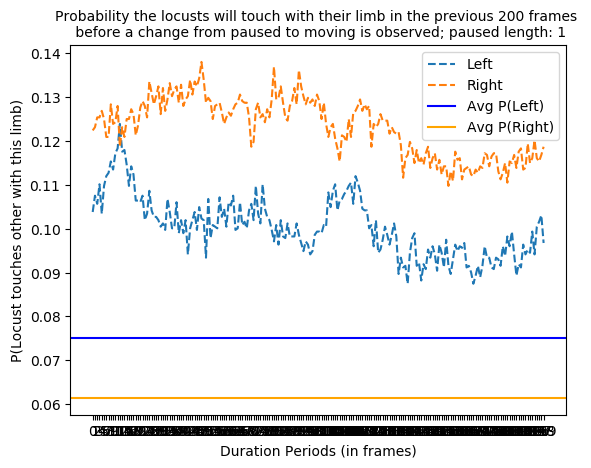

speed changes:  1046


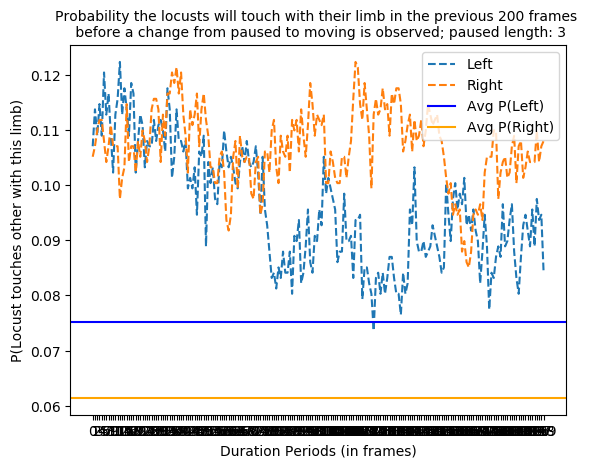

speed changes:  467


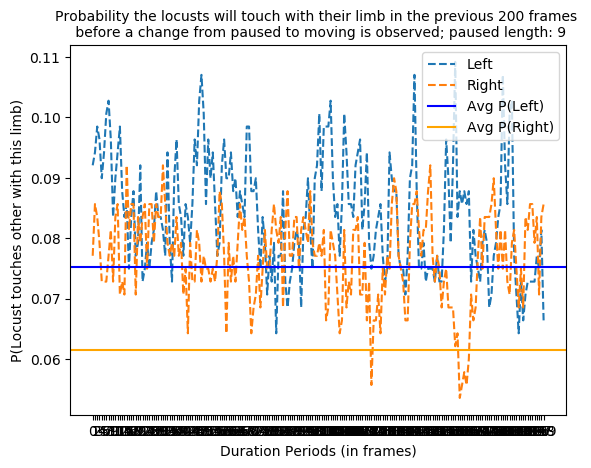

speed changes:  274


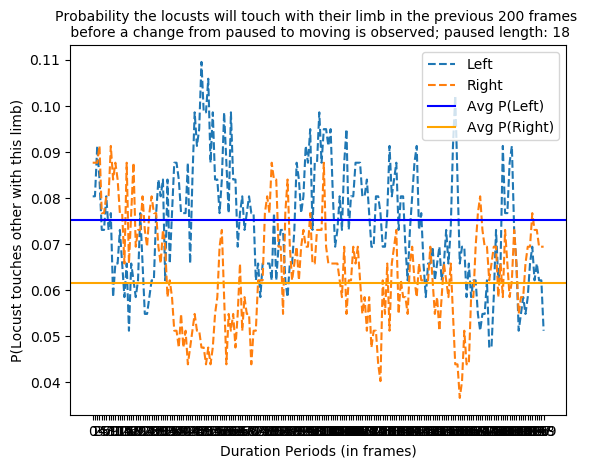

speed changes:  1231


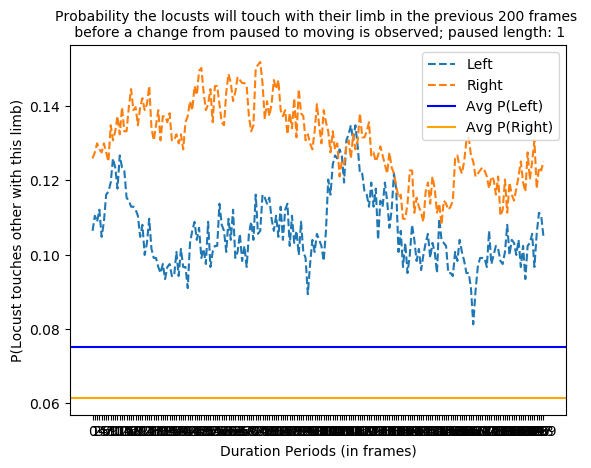

speed changes:  220


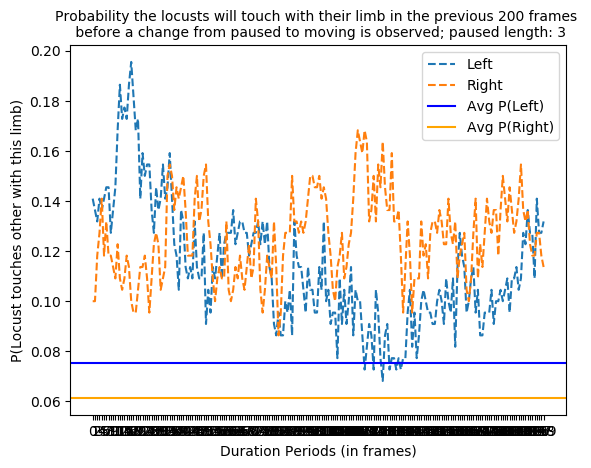

speed changes:  44


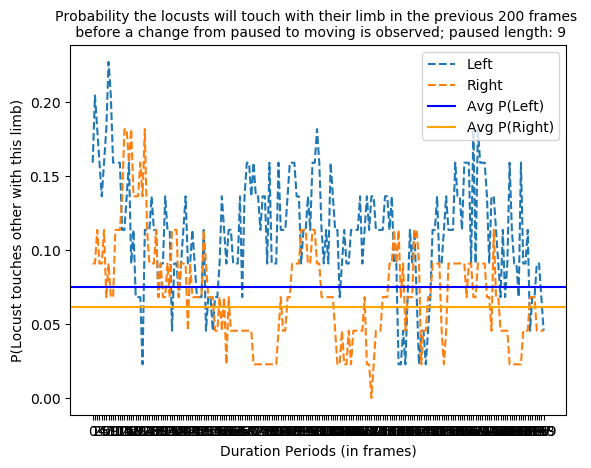

speed changes:  12


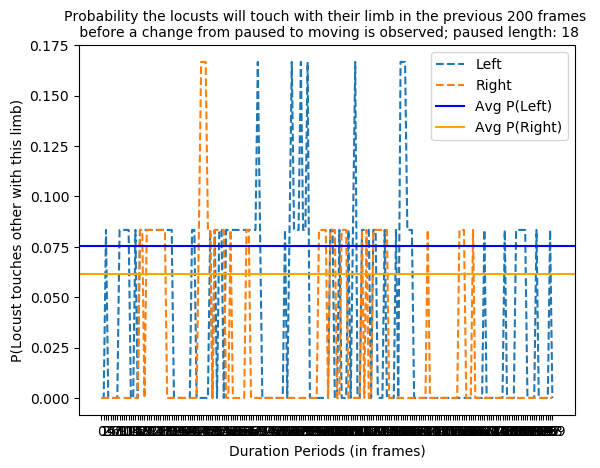

speed changes:  329


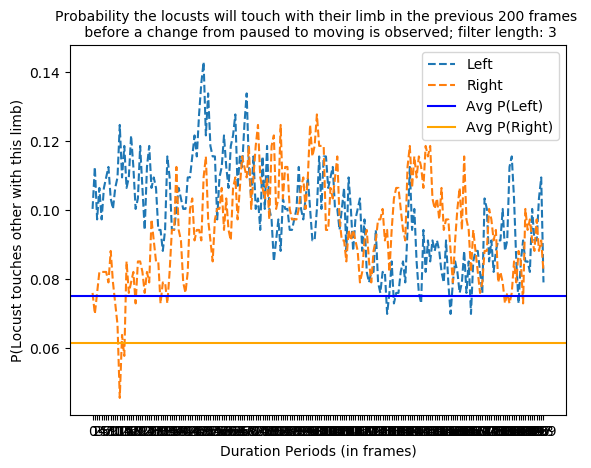

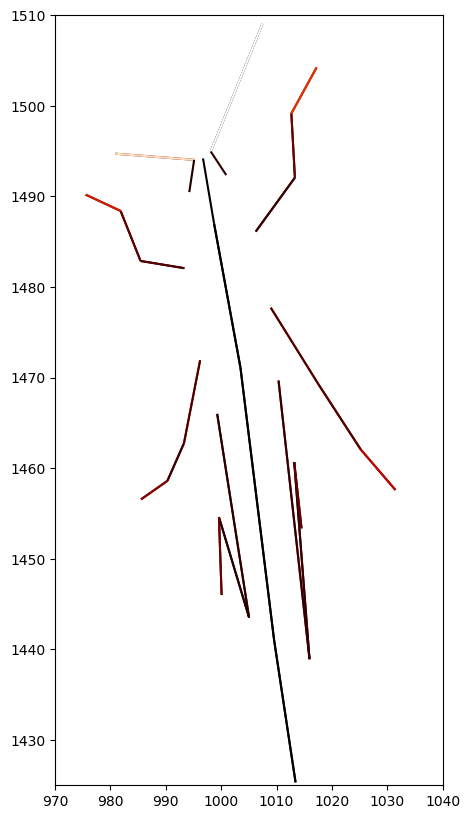

In [100]:
# get history of interaction where you include the paused length or greater
for pause_length in pause_lengths:
    history(X_LR, framesback, region, want_PL_or_Greater=True, pause_length=pause_length)

# get history of only instances with a paused length of x
for pause_length in pause_lengths:
    history(X_LR, framesback, region, want_PL_or_Greater=False, pause_length=pause_length)


# filter out the brief changes in motion, Keep data points where locust was paused for X frames, moving for X frames
filter_frames = 3
history(X_LR, framesback, region, want_PL_or_Greater=False, pause_length=np.nan, filter_frames=filter_frames)

# create heatmap of most frequent interactions per limb
heatmap(limb_count)

### Pairwise Locust's Limb Interactions

In [133]:
(neither_numb, ff_numb, fb_numb, bf_numb, bb_numb) = (0, 17, 31, 61, 199)
numb_list = [neither_numb, ff_numb, fb_numb, bf_numb, bb_numb]

In [134]:
case = ['FB_pairwise', 'Ant', 'Front', 'Middle', 'Back']

Functions

In [178]:
def pairwise_classification(classification):
    # fill up newX, to determine if it is touching the front/back 
    template=np.zeros((103,totalFrames,1))
    newX=np.full_like(template, np.nan)
    
    for locust in range(103):
        print(locust)
        for frame in range(totalFrames):
            
            with h5py.File('delete_this.h5', mode='r+') as h5file:
                X = h5file['delete'][locust, frame, :, :] # shape: (26, 26)

            interaction = np.sum(X)
                       
            if (interaction>1): # touching multiple limbs, see if there is one overall interaction 
                rows, cols = np.array(X.nonzero())
                classification_sum=0
                for idx in range(len(rows)):
                    classification_sum+=fb_classify(rows[idx], cols[idx], classification)
                avg_classification=0
                for numb in np.arange(1,5):
                    if (classification_sum / len(rows) == numb_list[numb]):
                        avg_classification=numb_list[numb]
                    else: # else if no overall interaction
                        avg_classification=neither_numb
                newX[locust, frame, 0] = avg_classification
                # print(avg_classification)

            if (interaction==1): # touching *one* other limb
                row, col = np.nonzero(X) # get index to identify the limb
                newX[locust, frame, 0] = fb_classify(row, col, classification) # get classification             
    return newX

def fb_classify(row, col, classification):
    a,b=(classification[row], classification[col])
    # print(a,b)
    if (a,b)==(0.0, 0.0): #FF
        # print('ff')
        return ff_numb
    elif (a,b)==(0.0, 1.0): #FB
        # print('fb')
        return fb_numb
    elif (a,b)==(1.0, 0.0): #BF
        # print('bf')
        return bf_numb
    elif (a,b)==(1.0, 1.0): #BB
        # print('bb')
        return bb_numb
    else:
        # print('neither')
        return neither_numb
    
def pairwise_history(newX, framesback, pause_length):
    ff=np.zeros(framesback)
    fb=np.zeros(framesback)
    bf=np.zeros(framesback)
    bb=np.zeros(framesback)

    speed_changes = 0
    for individ in range(y.shape[0]):
        for frame in range(framesback, y.shape[1]):
            past=0
            for prev in range(pause_length):
                past += y[individ, frame-(prev+1)] # 0
            # if the locust has a consecutive pause of length (pause_length) and it goes into moving state
            if past==0 and y[individ, frame-(pause_length+1)]==1: 
            # if the locust moves from paused to moving
                if (y[individ, frame] - y[individ, frame-1])==1: 
                    speed_changes+=1
                    # get array of past X frames
                    # to do: check for a consecutive pause
                    for frameback in range(framesback):
                        if newX[individ, frame-frameback]==ff_numb:
                            ff[frameback]+=1
                        if newX[individ, frame-frameback]==fb_numb:
                            fb[frameback]+=1
                        if newX[individ, frame-frameback]==bf_numb:
                            bf[frameback]+=1
                        if newX[individ, frame-frameback]==bb_numb:
                            bb[frameback]+=1
    print("speed changes: ", speed_changes)
    return ff, fb, bf, bb, speed_changes

def plot_pairwise(ff, fb, bf, bb, framesback, avg_pairwise, pause_length):
    
    ind = np.arange(framesback)  # the x locations for the groups
    fig, ax = plt.subplots()
    labels_pair = ['FF', 'FB', 'BF', 'BB']

    plt.plot(ind, ff, label=labels_pair[0], linestyle=':')
    plt.plot(ind, fb, label=labels_pair[1], linestyle=':')
    plt.plot(ind, bf, label=labels_pair[2], linestyle=':')
    plt.plot(ind, bb, label=labels_pair[3], linestyle=':')
    
    for idx, avg in enumerate(avg_pairwise):
        plt.axhline(y=avg, color=colors[idx], linestyle='-')
    
    plt.legend(bbox_to_anchor=(1, 1), loc=1, fontsize=20)

    ax.set_xlabel('Number of frames back in time', fontsize=20)
    ax.set_ylabel('P (Moving Locust)', fontsize=20)
    ax.set_title('Probability the locusts will engage in the interaction in the previous %d frames before a change from paused to moving is observed; paused length: %d' % (framesback, pause_length), fontsize=20)
    ax.set_xticks(np.arange(0, framesback, 10))
    ax.set_xticklabels(np.arange(0, framesback, 10))
    fig.set_size_inches((40, 12))
    
    fig.savefig('./plots/pairwise/pairwise_%d.png' % pause_length)
    plt.show()
    
def get_duration(pairwise_X, numb, locust, frame, marked):
    if pairwise_X[locust, frame, 0]==numb:
        length=0
        while pairwise_X[locust, frame, 0]==numb:
            marked[locust, frame, 0]=True
            length+=1
            if frame==(pairwise_X.shape[1]-1):
                break
            else: 
                frame+=1
    return length, marked

Plots

In [140]:
pairwise_X = pairwise_classification(classification_fb)

Average Probability of Pairwise Interactions (FF, FB, BF, BB)

In [176]:
unique, counts = np.unique(pairwise_X, return_counts=True)
print("unique: ", unique[0:5], " counts: ", counts[0:5])

avg_pairwise=np.array([counts[1]/(totalFrames*103), counts[2]/(totalFrames*103), counts[3]/(totalFrames*103), counts[4]/(totalFrames*103)])  

unique:  [  0.  17.  31.  61. 199.]  counts:  [11255  1881  1713  1545    94]


speed changes:  1231


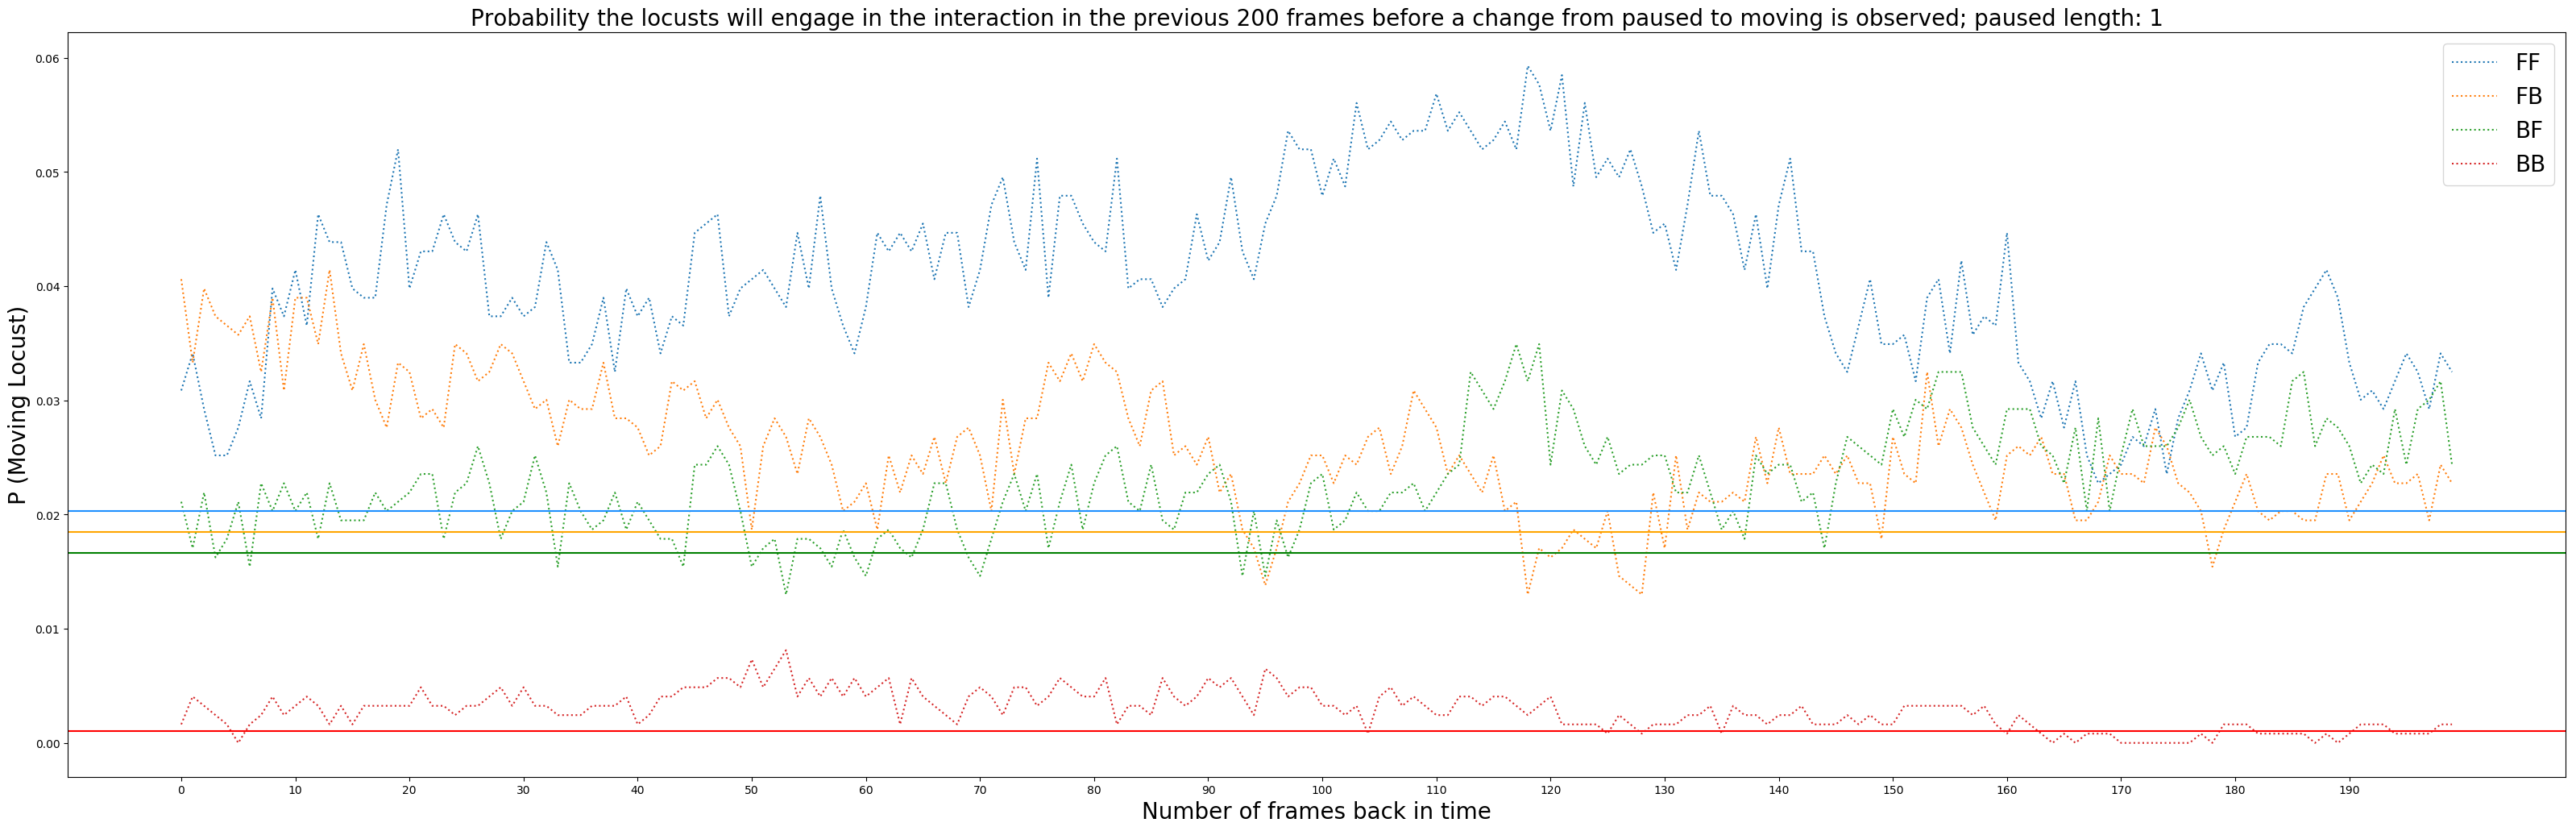

speed changes:  220


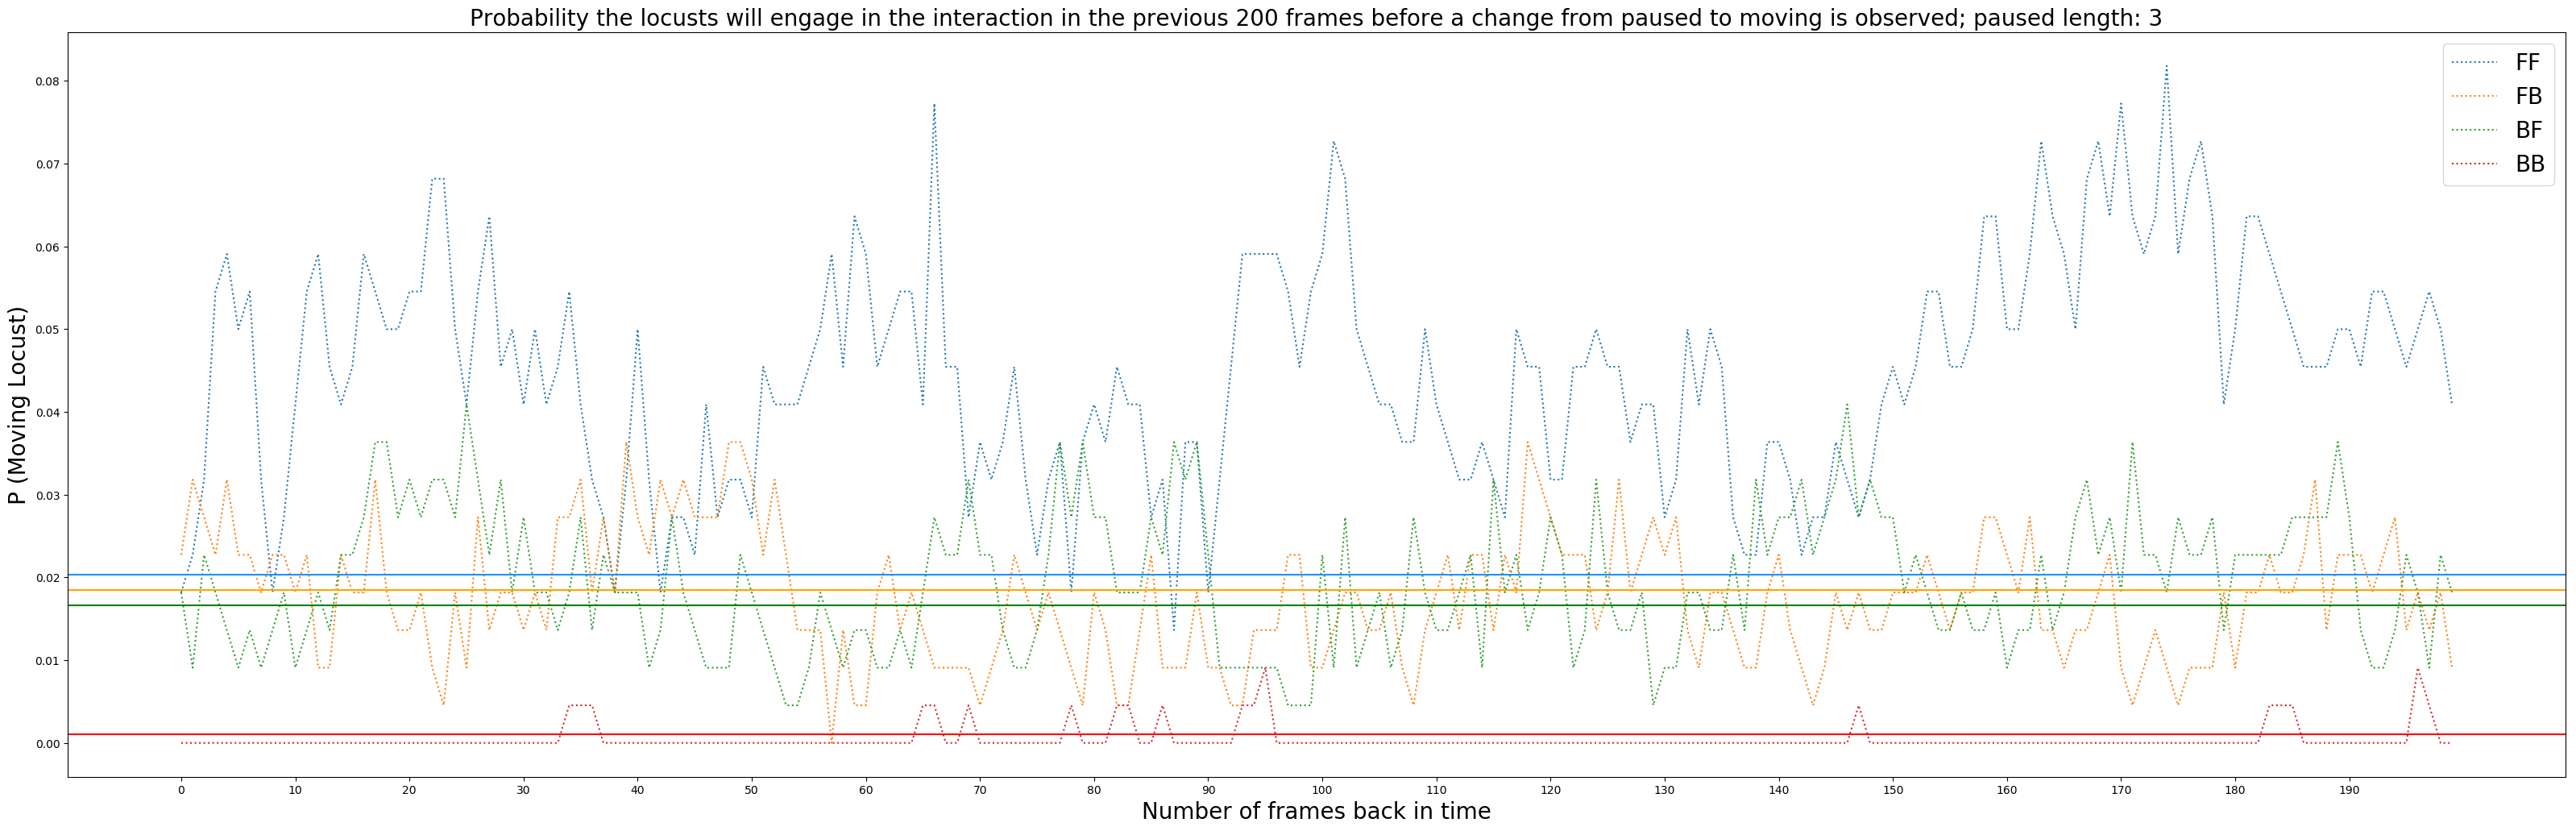

speed changes:  44


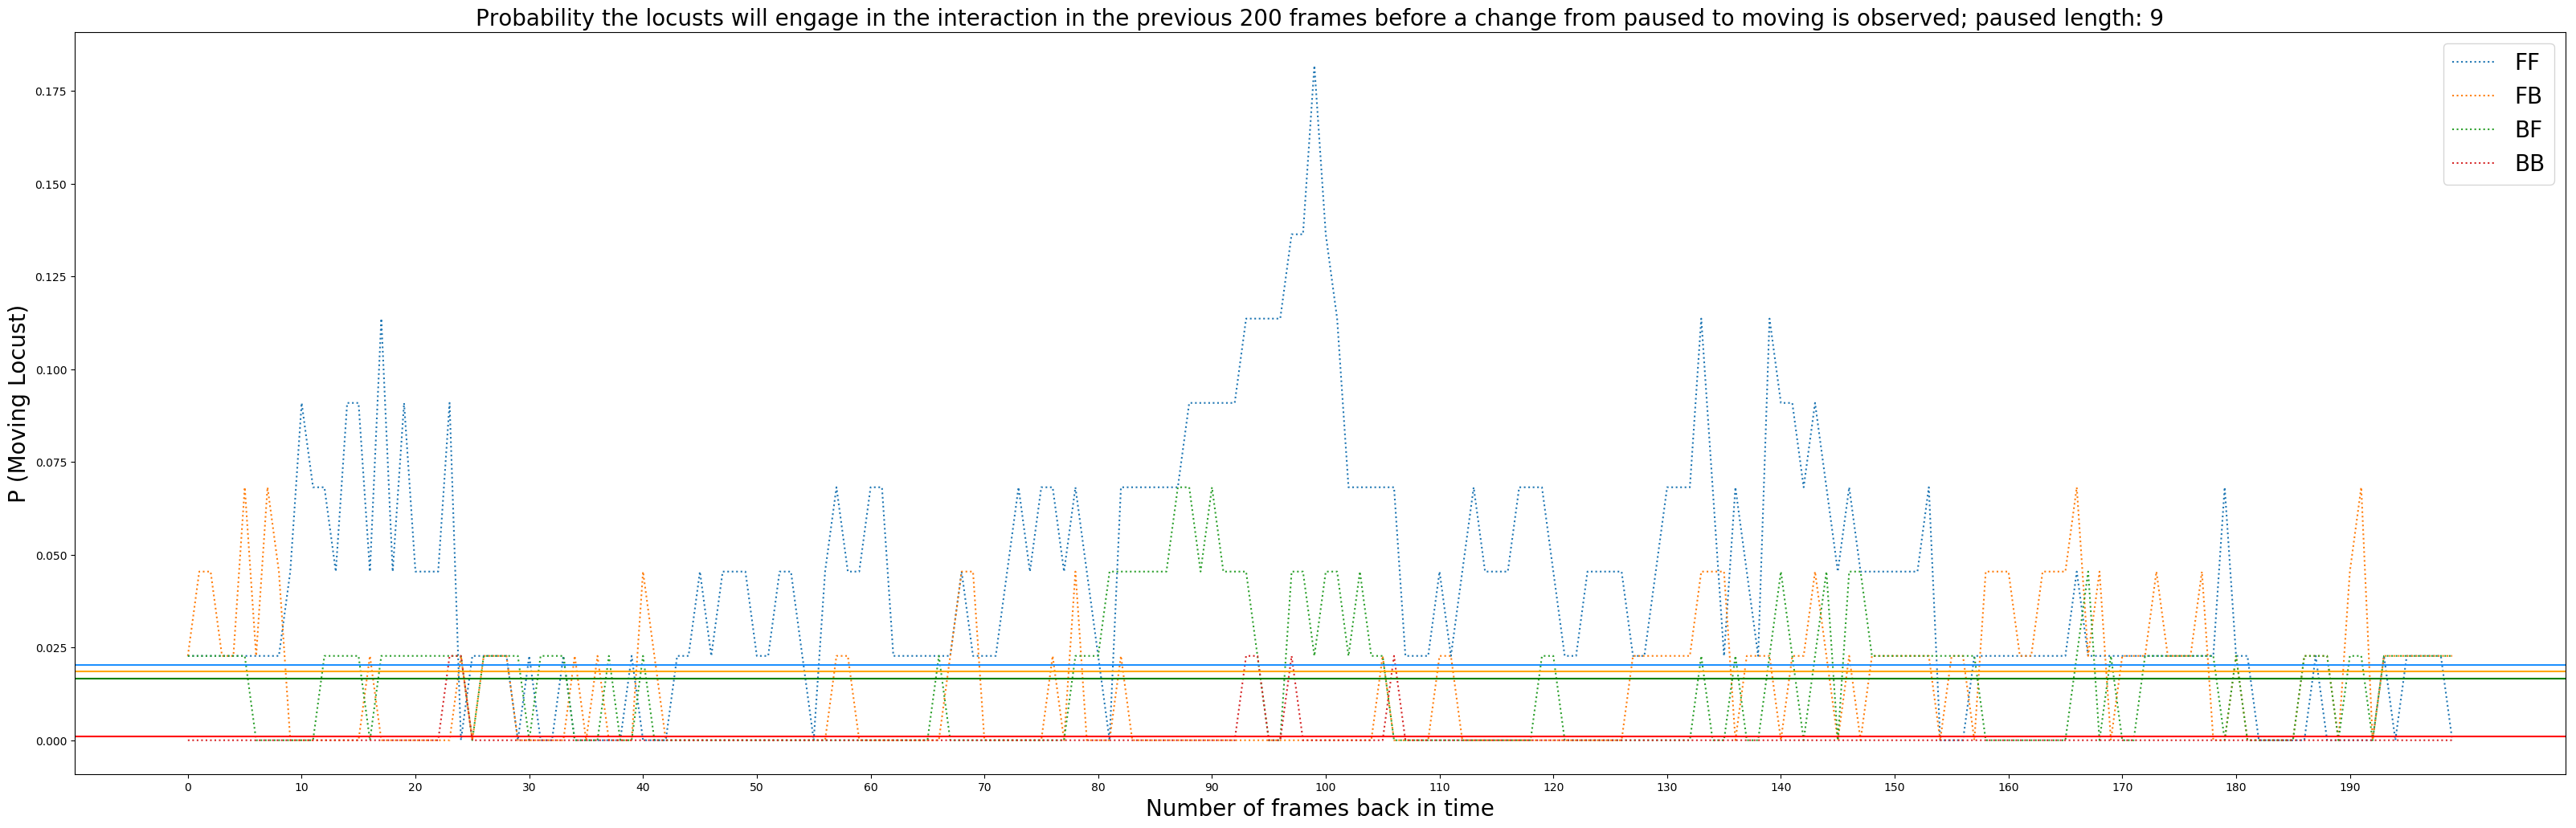

speed changes:  12


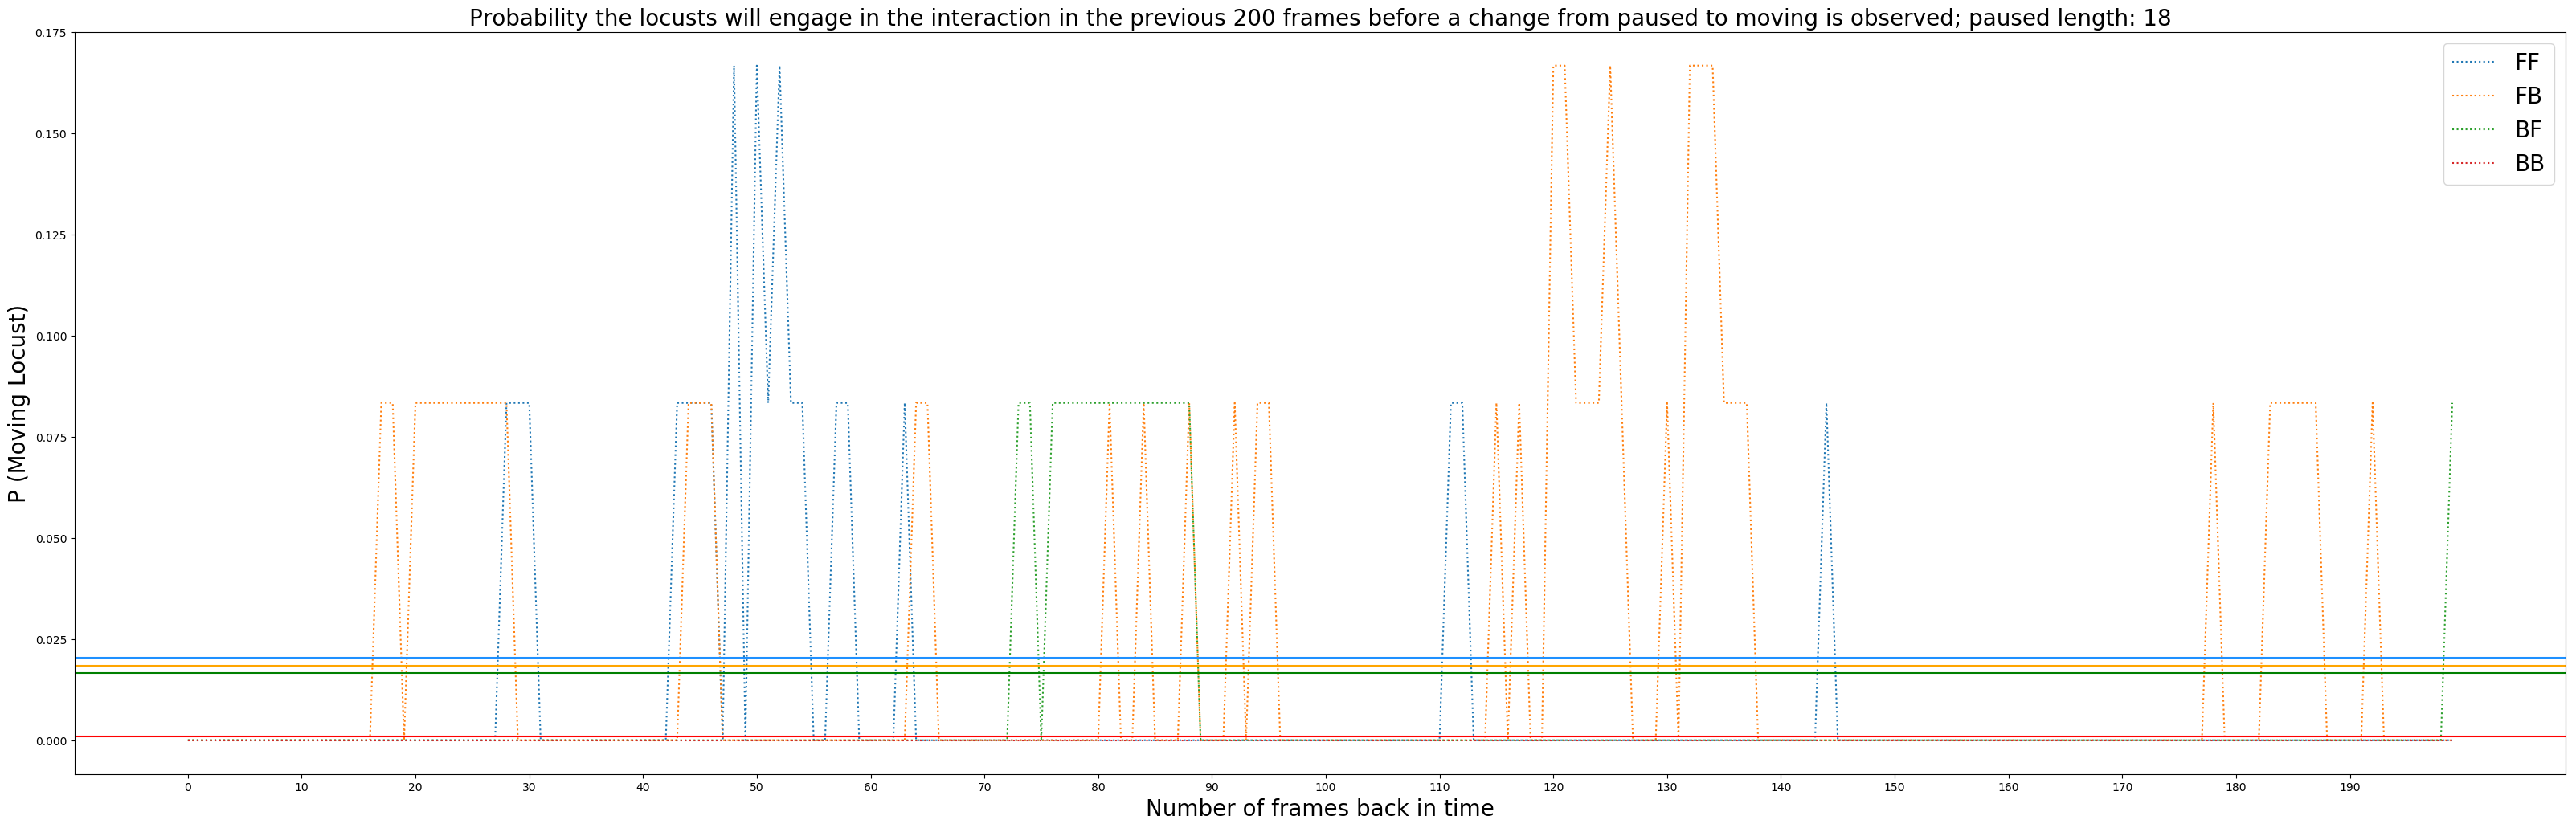

In [179]:
for pause_length in pause_lengths:
    ff, fb, bf, bb, speed_changes = pairwise_history(pairwise_X, framesback=framesback, pause_length=pause_length)
    plot_pairwise(ff/speed_changes, fb/speed_changes, bf/speed_changes, bb/speed_changes, framesback, avg_pairwise, pause_length=pause_length)

In [170]:
def histo(counts, title, xlabel, location, labels=[], log=False):
    num_bins =  1 + int(3.322*math.log(len(counts)))
    if num_bins < 4:
        num_bins =  1 + int(3.322*math.log(len(counts[0])))
        n, bins, patches = plt.hist(counts, num_bins, log=log, label=labels)
    else:
        n, bins, patches = plt.hist(counts, num_bins, log=log)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.savefig(location)
    # plt.legend()
    plt.show()

In [145]:
def graph_title(region):
    title=('Distribution of Length of %s Interactions across the Entire Experiment' % region)
    xlabel='Length of the Interaction (frames)'
    location=('./plots/pairwise/%s_length_histo.png' % region)
    return title, xlabel, location

Plot All Distribution on the Same Histogram

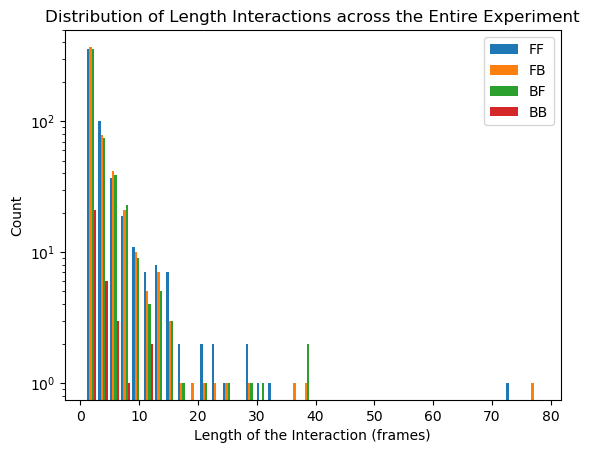

In [181]:
log=True
title=('Distribution of Length Interactions across the Entire Experiment')
xlabel='Length of the Interaction (frames)'
location=('./plots/pairwise/all_histo.png')

x_multi=[]
x_multi.append(ff_length)
x_multi.append(fb_length)
x_multi.append(bf_length)
x_multi.append(bb_length)

# bins =  1 + int(3.322*math.log(len(ff_length)))

bins=40

n, bins, patches = plt.hist(x_multi, bins, log=log, label=['FF', 'FB', 'BF', 'BB'])

plt.title(title)
plt.xlabel(xlabel)
plt.ylabel('Count')
plt.savefig(location)
plt.legend()
plt.show()

No handles with labels found to put in legend.


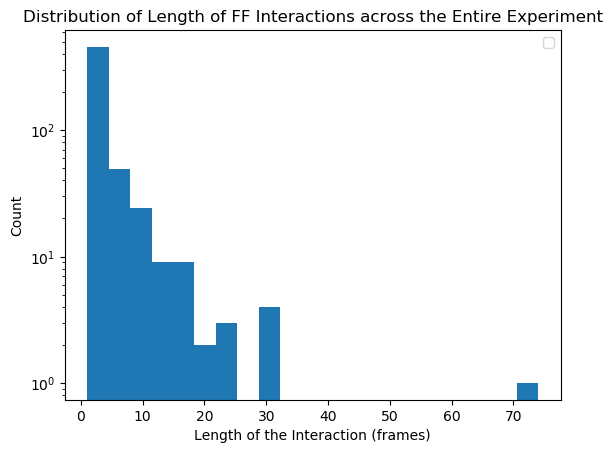

In [169]:
title, xlabel, location=graph_title('FF')
histo(ff_length, title, xlabel, location, log=True)

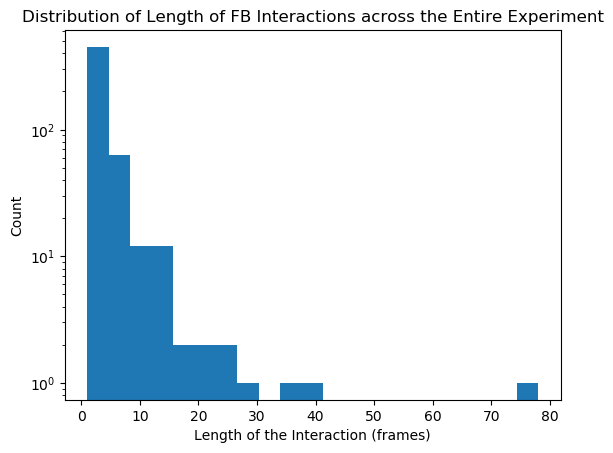

In [171]:
title, xlabel, location=graph_title('FB')
histo(fb_length, title, xlabel, location, log=True)

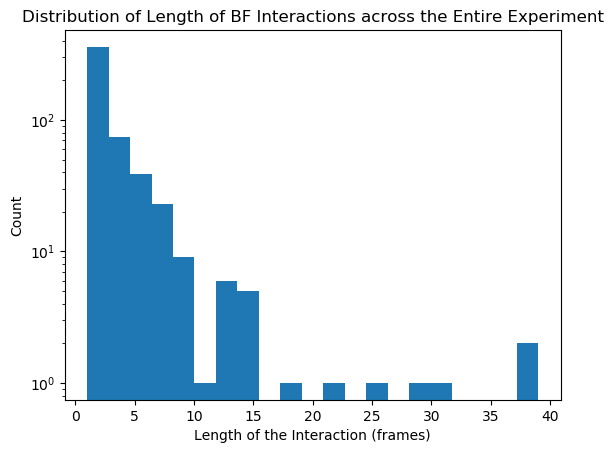

In [172]:
title, xlabel, location=graph_title('BF')
histo(bf_length, title, xlabel, location, log=True)

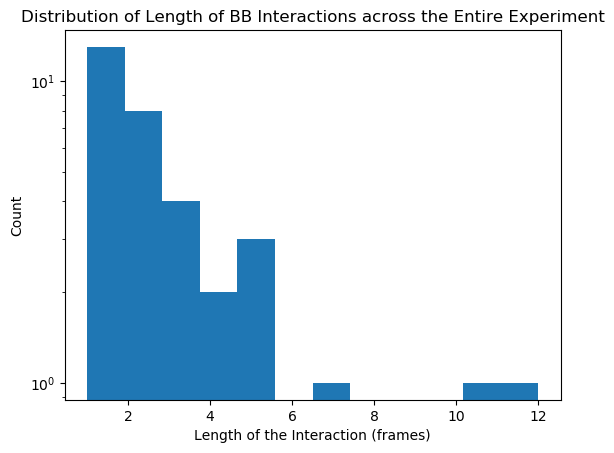

In [173]:
title, xlabel, location=graph_title('BB')
histo(bb_length, title, xlabel, location, log=True)

#### Antennae/Front/Middle/Back Pairwise Interactions

In [174]:
AFMB_pair= np.array([['AA', 'AF', 'AM', 'AB'], 
            ['FA', 'FF', 'FM', 'FB'], 
            ['MA', 'MF', 'MM', 'MB'], 
            ['BA', 'BF', 'BM', 'BB']])

keys=np.reshape(AFMB_pair, -1)
all_numbs=[2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53]
AFMB_dict = dict(zip(keys, all_numbs))

In [186]:
def AFMBpair_classification(classification):
    # fill up newX, to determine if it is touching the AFMB
    template=np.zeros((103, totalFrames,1))
    newX=np.full_like(template, np.nan)
    
    for locust in range(103):
        for frame in range(totalFrames):
            
            with h5py.File('delete_this.h5', mode='r+') as h5file:
                X = h5file['delete'][locust, frame, :, :] # shape: (26, 26)

            interaction = np.sum(X)
                       
            if (interaction>1): # touching multiple limbs, see if there is one overall interaction 
                rows, cols = np.array(X.nonzero())
                classification_sum=0
                for idx in range(len(rows)): # for each number of limb interactions
                    classification_sum+=AFMB_classify(rows[idx], cols[idx], classification)
                
                avg_classification=classification_sum/len(rows) # avoids overlaps because numbs are prime

                for pair_interaction in AFMB_dict:
                    # if avg_classification equals the interaction's corresponding number
                    if (avg_classification==AFMB_dict[pair_interaction]):
                        newX[locust, frame, 0]=avg_classification
                    else: # no overall interaction (includes interactions of mixed body parts)
                        avg_classification=-1
                        newX[locust, frame, 0]=avg_classification

            if (interaction==1): # touching *one* other limb
                row, col = np.nonzero(X) # get index to identify the limb
                newX[locust, frame, 0] = AFMB_classify(row, col, classification) # get classification             
    return newX

def AFMB_classify(row, col, classification):
    a,b=(classification[row], classification[col])
    if (not np.isnan(a) and not np.isnan(b)):
        a=int(a)
        b=int(b)
        idxA=np.where(np.unique(classification_AFMB)[0:AFMB_pair.shape[0]]==a)[0][0]
        idxB=np.where(np.unique(classification_AFMB)[0:AFMB_pair.shape[0]]==b)[0][0]
        numb = AFMB_dict[AFMB_pair[idxA][idxB]]
        # print(numb)
        return numb
    else:
        return 0
    
def pairwise_history(newX, framesback, pause_length):
    
    # create dict to store the history
    n = len(all_numbs)
    lists = [np.zeros(framesback) for _ in range(n)]
    history = dict(zip(all_numbs, lists))

    
    speed_changes = 0
    for individ in range(y.shape[0]): # cannot proceed if X and y do not match
        for frame in range(framesback, y.shape[1]):
            past=0
            for prev in range(pause_length):
                past += y[individ, frame-(prev+1)] # 0
            # if the locust has a consecutive pause of length (pause_length) and it goes into moving state
            if past==0 and y[individ, frame-(pause_length+1)]==1: 
            # if the locust moves from paused to moving
                if (y[individ, frame] - y[individ, frame-1])==1: 
                    speed_changes+=1
                    # get array of past X frames
                    # to do: check for a consecutive pause
                    for frameback in range(framesback):
                        # history[newX[individ, frame-frameback]][frameback]+=1
                        interaction_id_numb = newX[individ, frame-frameback,0]
                        if not (np.isnan(interaction_id_numb) or interaction_id_numb==0 or interaction_id_numb==-1):
                            history[interaction_id_numb][frameback]+=1
                        
    print("speed changes: ", speed_changes)
    return history, speed_changes

def plot_pairwise(region, A, F, M, B, framesback, labels, pause_length):
    
    ind = np.arange(framesback)  # the x axis
    fig, ax = plt.subplots()

    plt.plot(ind, A, label=labels[0], linestyle='--')
    plt.plot(ind, F, label=labels[1], linestyle='--')
    plt.plot(ind, M, label=labels[2], linestyle='--')
    plt.plot(ind, B, label=labels[3], linestyle='--')
    
    plt.legend(bbox_to_anchor=(1, 1), loc=1, fontsize=20)

    ax.set_xlabel('Number of frames back in time', fontsize=20)
    ax.set_ylabel('P (Moving Locust)', fontsize=20)
    ax.set_title('Probability Locusts will Engage in the Interaction with the %s in the Previous %d frames before a Change from A Paused Length of %d to Moving is Observed' 
                 % (region, framesback, pause_length), fontsize=20)
    ax.set_xticks(np.arange(0, framesback, 10))
    ax.set_xticklabels(np.arange(0, framesback, 10))
    fig.set_size_inches((40, 12))
    
    fig.savefig('./plots/pairwise/%s_pairwise_%d.png' % (region, pause_length))
    plt.show()
    
def get_duration(pairwise_X, numb, locust, frame, marked):
    if pairwise_X[locust, frame, 0]==numb:
        length=0
        while pairwise_X[locust, frame, 0]==numb:
            marked[locust, frame, 0]=True
            length+=1
            if frame==(pairwise_X.shape[1]-1):
                break
            else: 
                frame+=1
    return length, marked

In [187]:
pairwise_AFMB = AFMBpair_classification(classification_AFMB)

In [188]:
unique, counts = np.unique(pairwise_AFMB, return_counts=True)
unique[0:16], counts[0:16]

(array([-1.,  0.,  2.,  3.,  5.,  7., 11., 13., 17., 19., 23., 29., 31.,
        37., 41., 43.]),
 array([7950, 1444,  850,  286,  531,  593,  293,  428,  687,  486,  473,
         676,  444,  167,  510,  488], dtype=int64))

speed changes:  11055


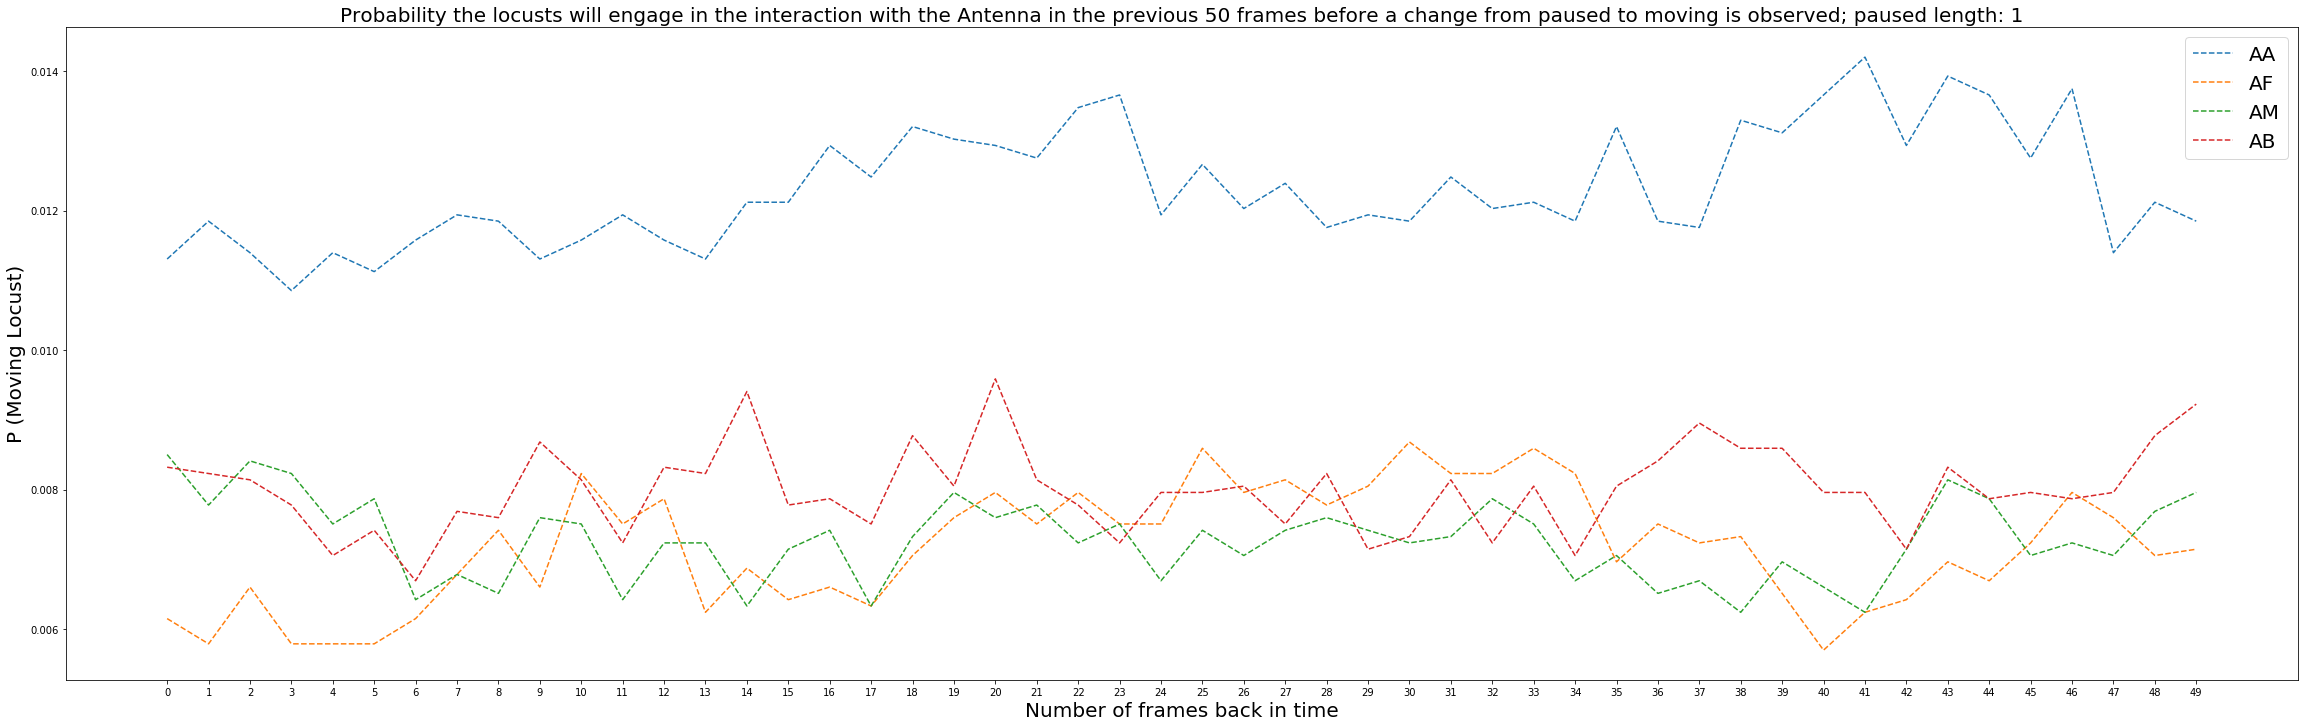

speed changes:  1843


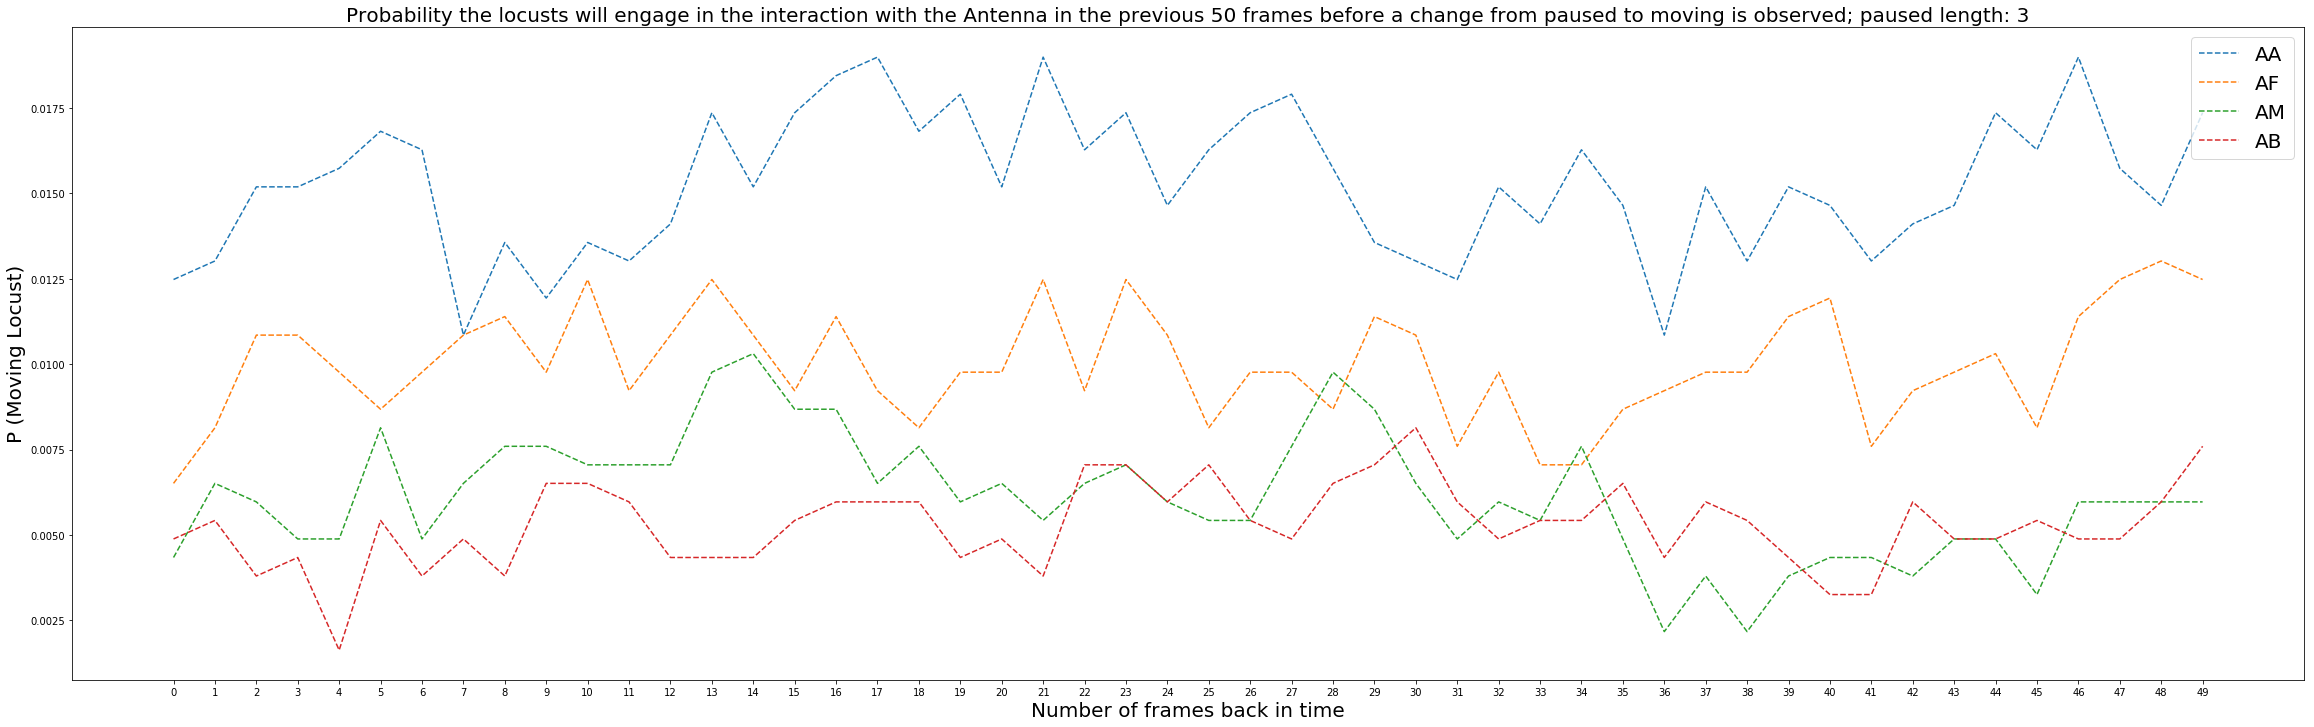

speed changes:  291


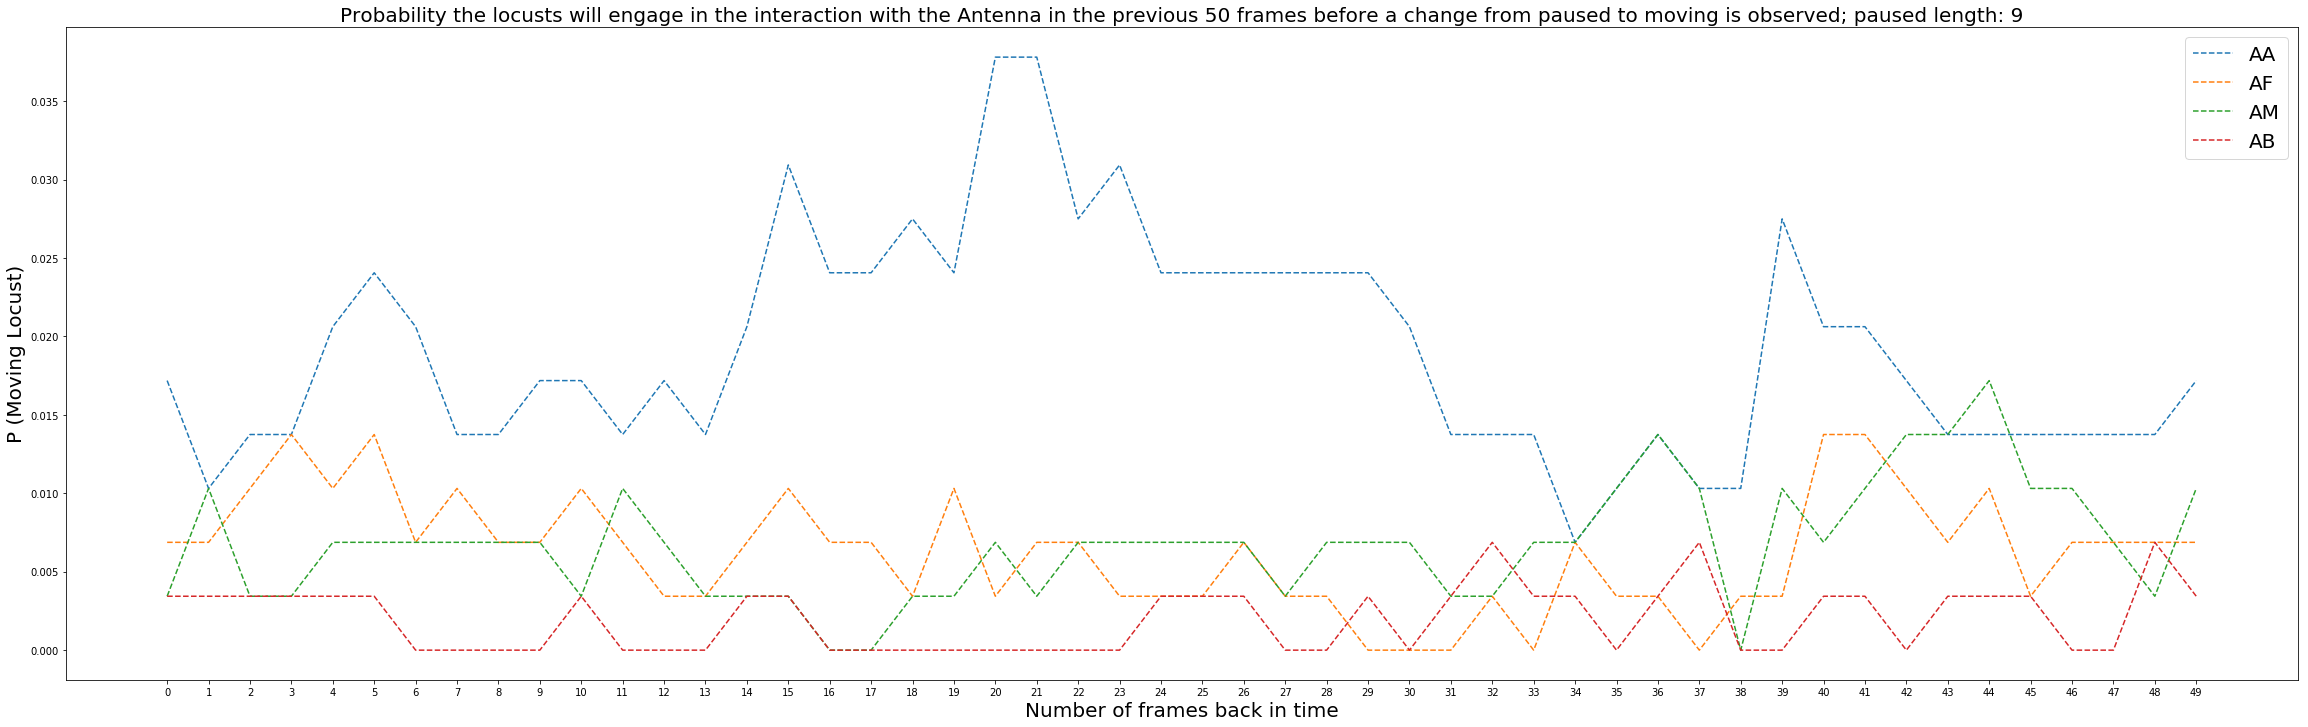

speed changes:  92


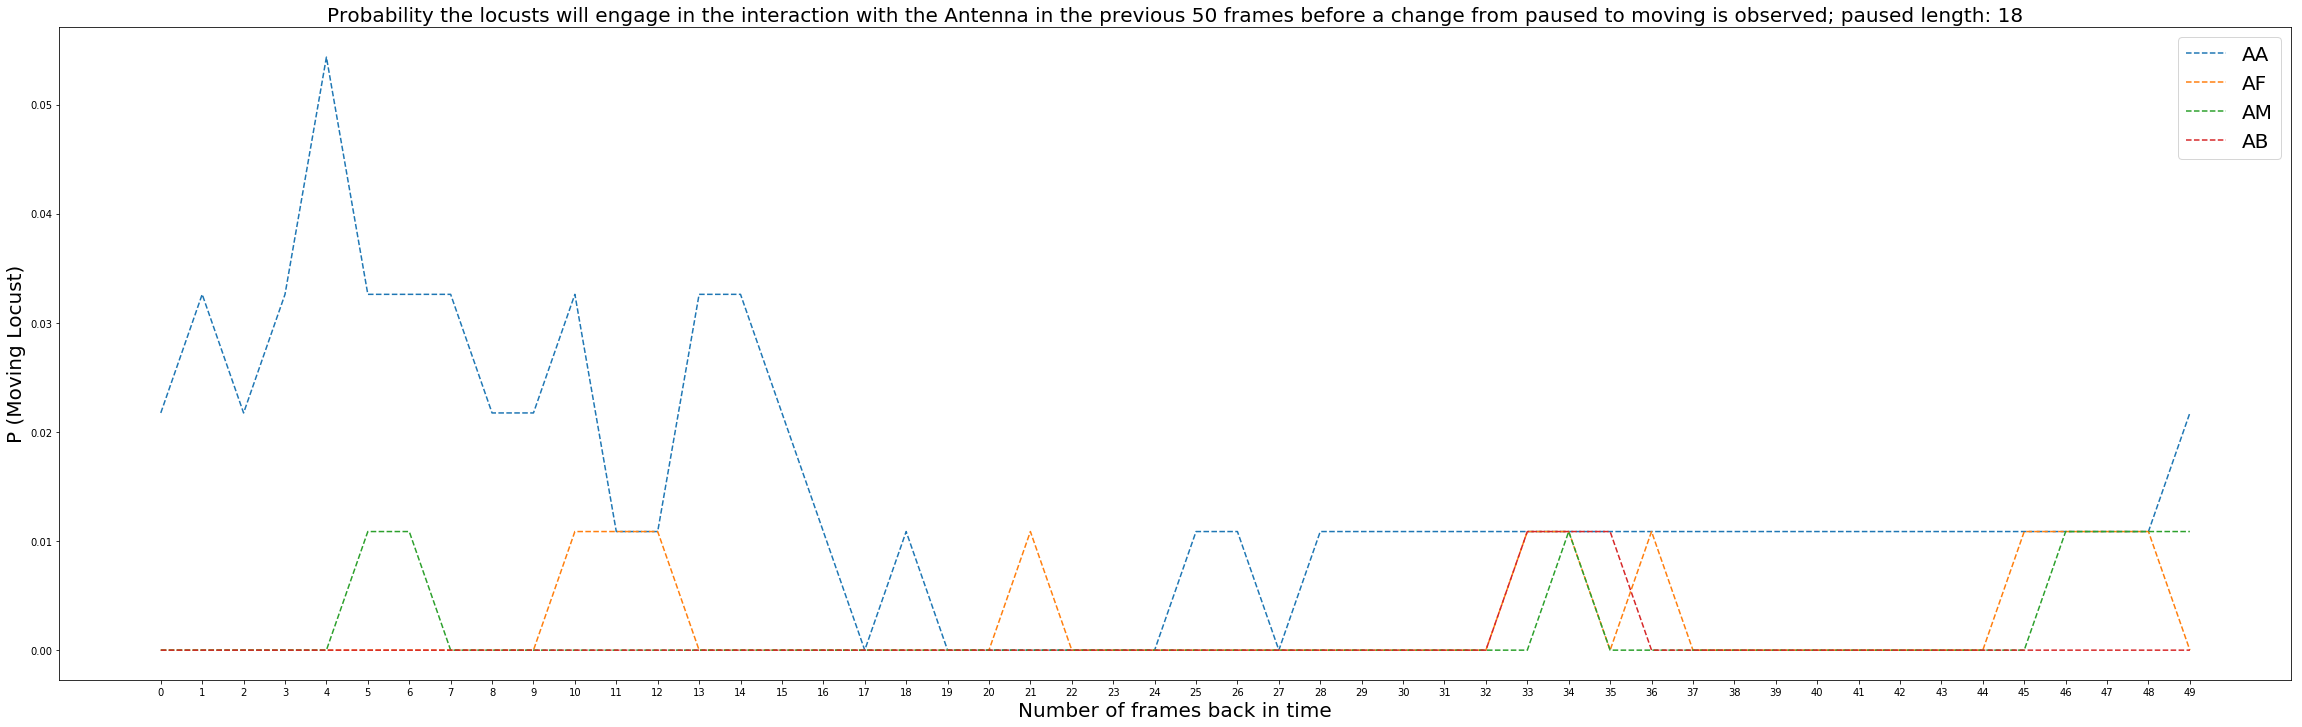

In [150]:
region = "Antenna"
labels = ['AA', 'AF', 'AM', 'AB']

avg_ant=np.array([ant_count/(totalFrames*103), front_count/(totalFrames*103), mid_count/(totalFrames*103), back_count/(totalFrames*103)])


for pause_length in pause_lengths:
    history, sc = pairwise_history(pairwise_AFMB, framesback=framesback, pause_length=pause_length)
    plot_pairwise(region=region, A=history[AFMB_dict[labels[0]]]/sc, F=history[AFMB_dict[labels[1]]]/sc, M=history[AFMB_dict[labels[2]]]/sc, B=history[AFMB_dict[labels[3]]]/sc, 
                  framesback=framesback, labels=labels, pause_length=pause_length)

speed changes:  11055


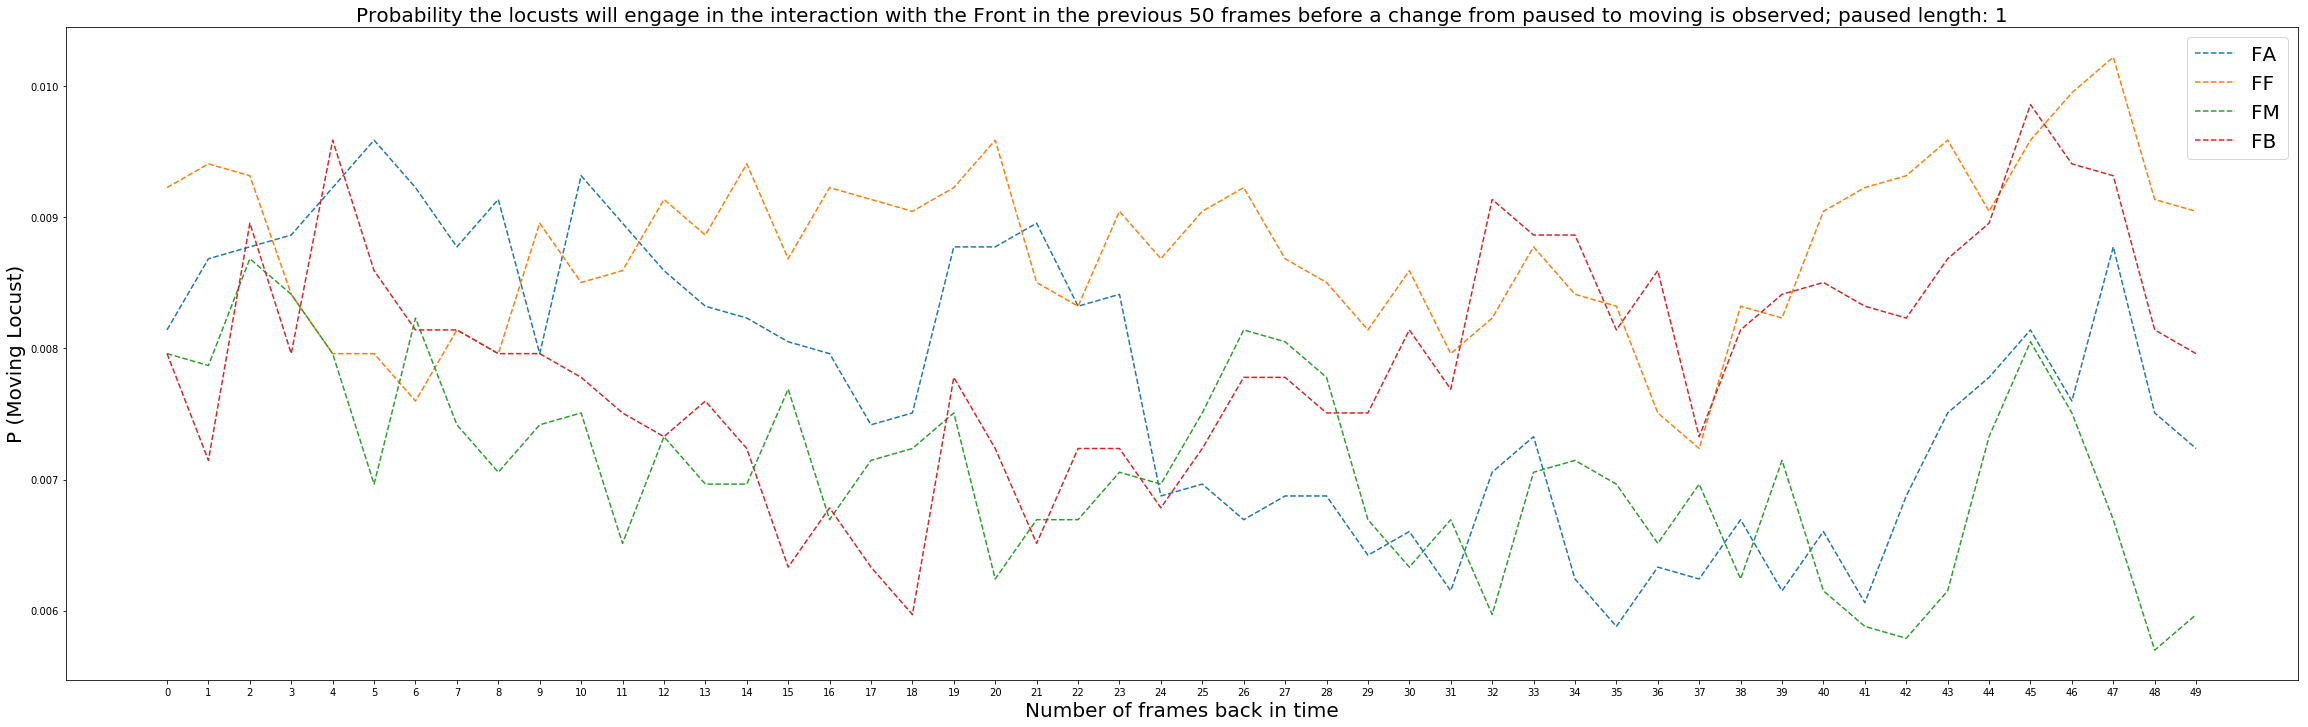

speed changes:  1843


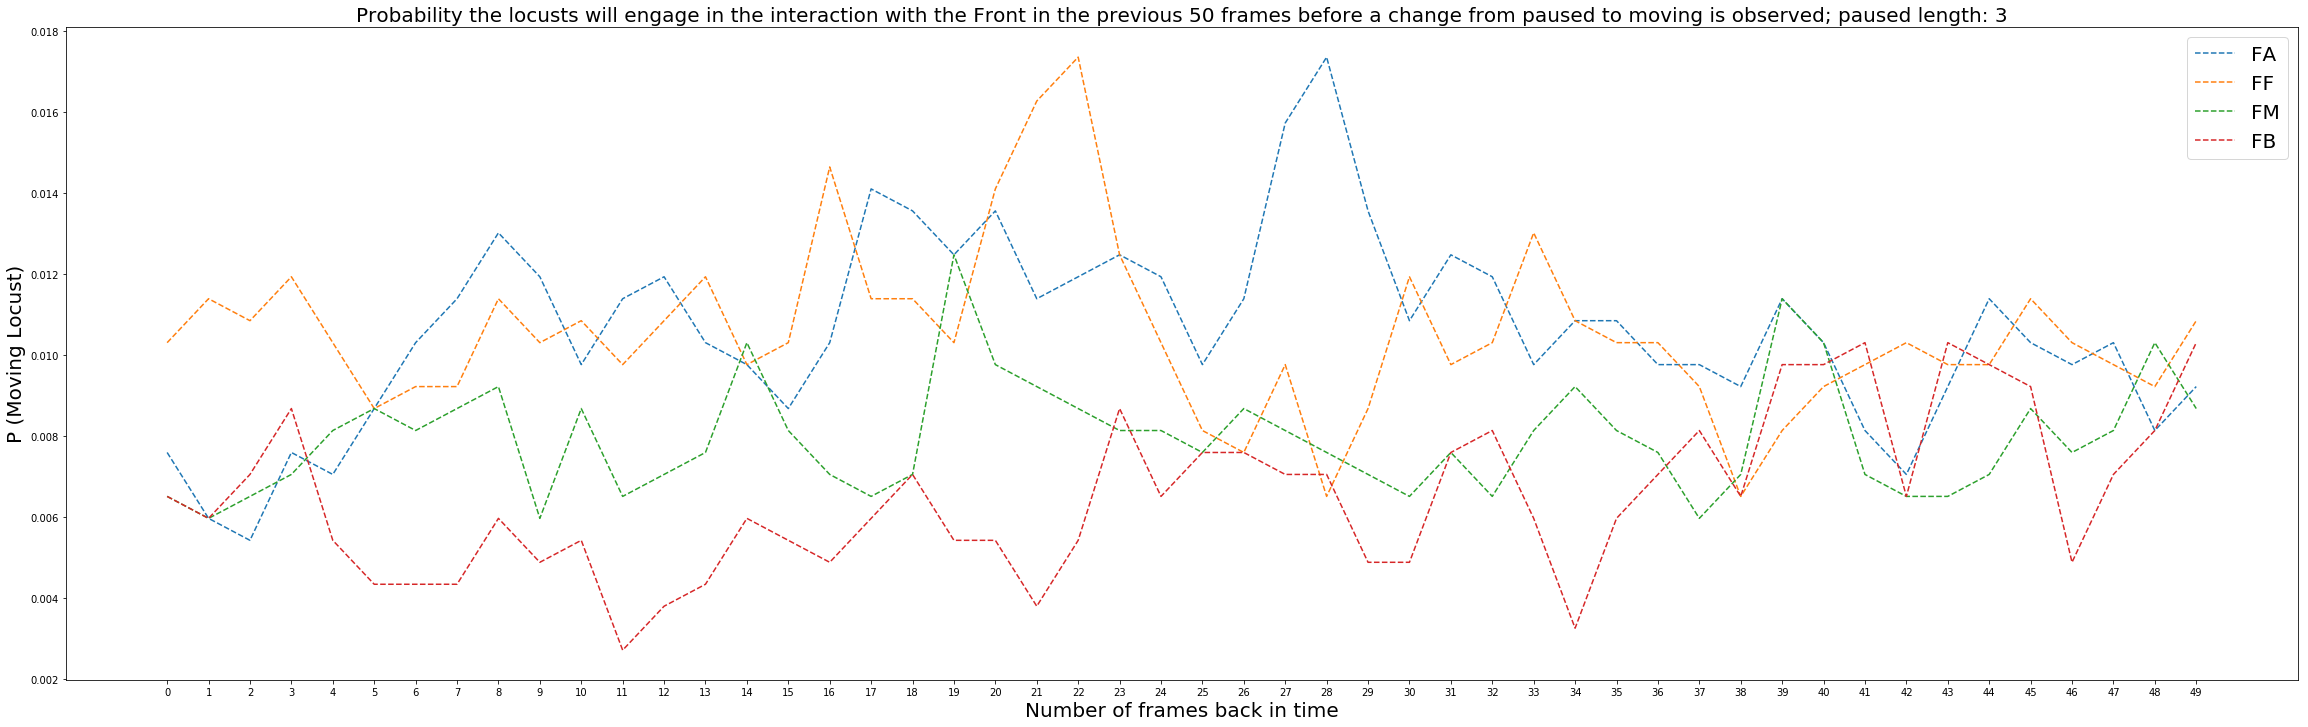

speed changes:  291


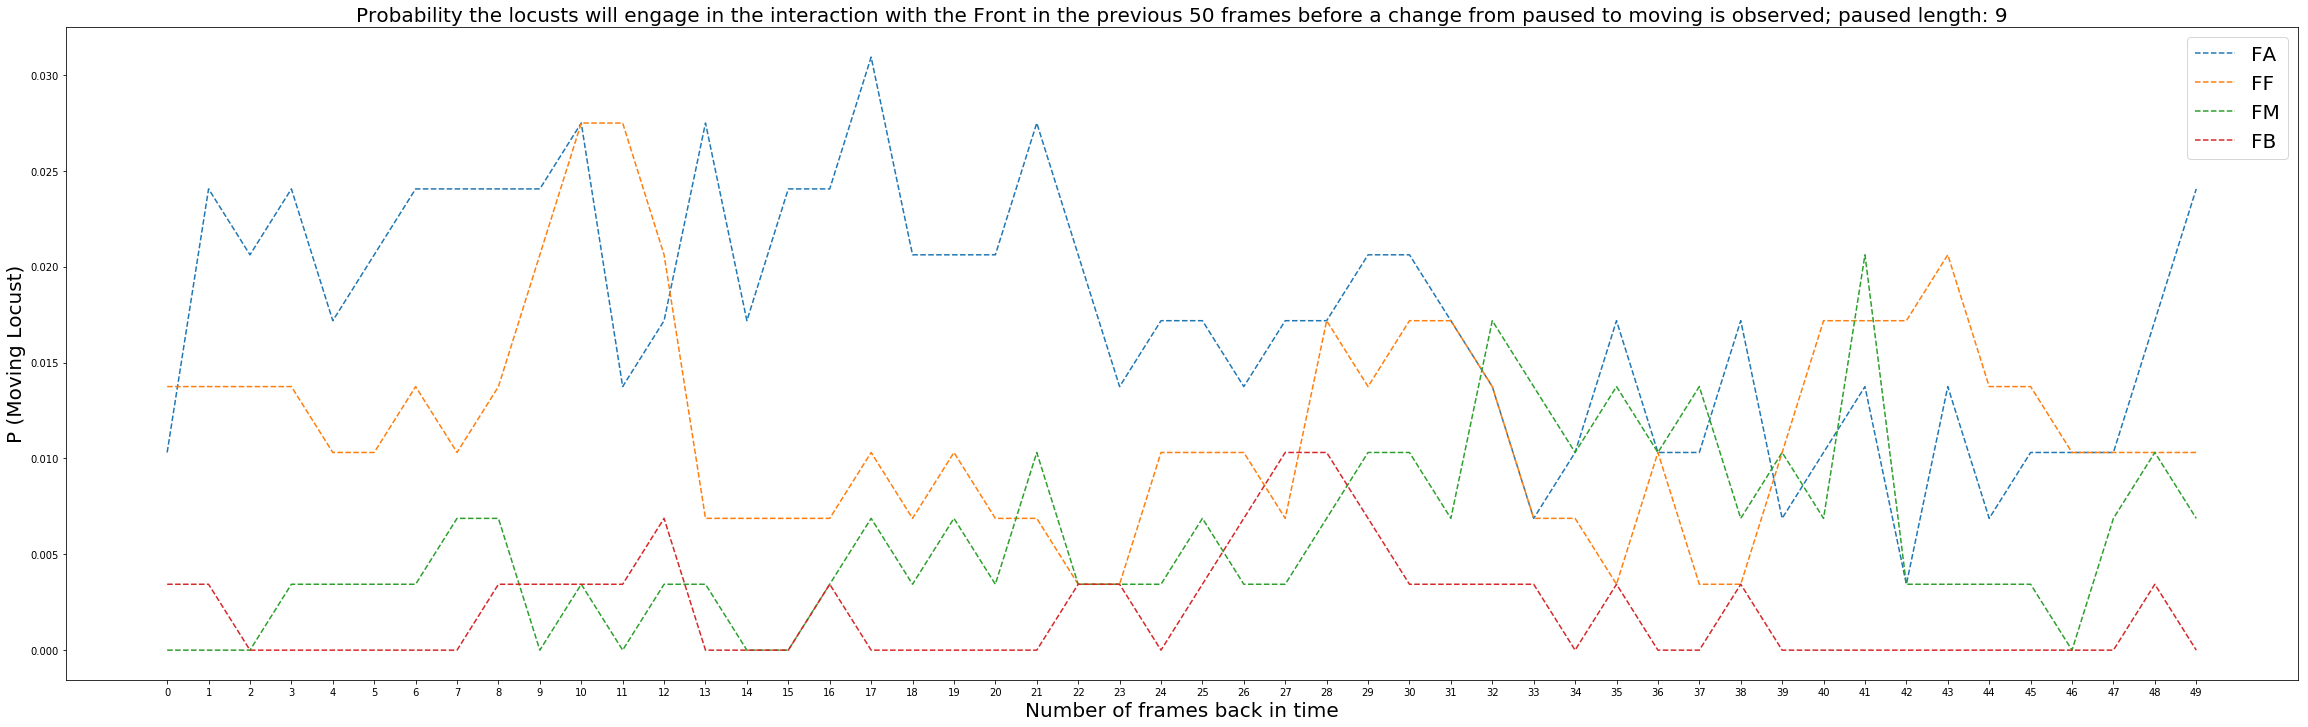

speed changes:  92


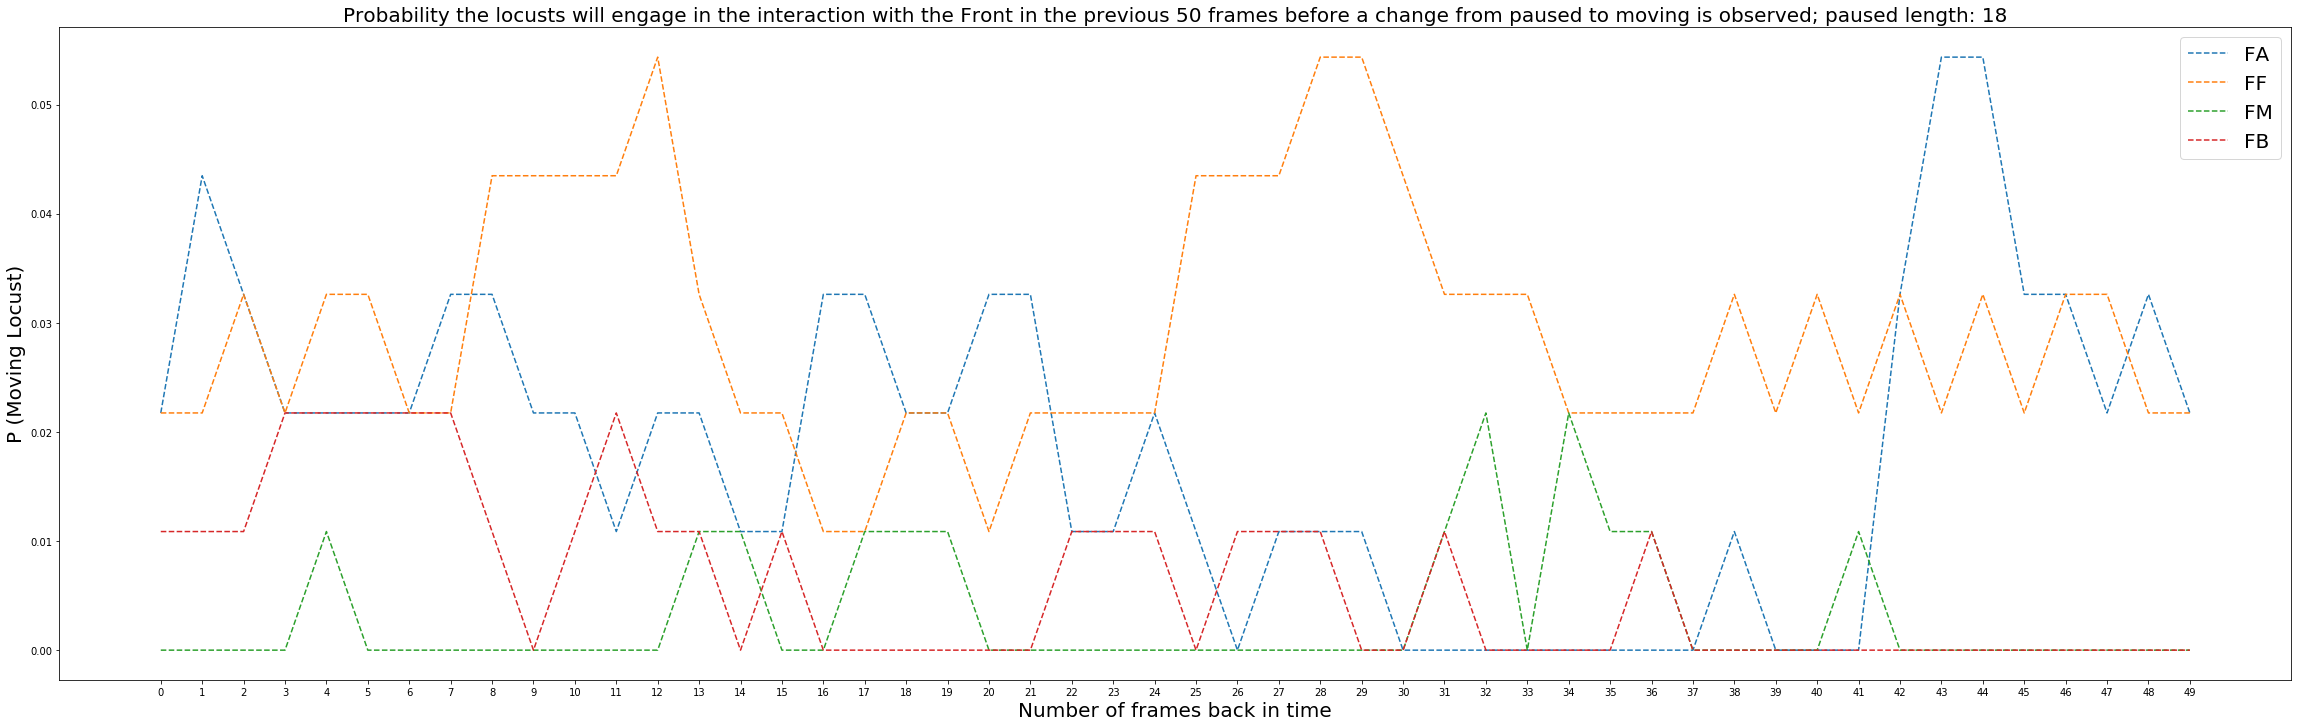

In [151]:
region = "Front"
labels = ['FA', 'FF', 'FM', 'FB']

for pause_length in pause_lengths:
    history, sc = pairwise_history(pairwise_AFMB, framesback=framesback, pause_length=pause_length)
    plot_pairwise(region=region, A=history[AFMB_dict[labels[0]]]/sc, F=history[AFMB_dict[labels[1]]]/sc, M=history[AFMB_dict[labels[2]]]/sc, B=history[AFMB_dict[labels[3]]]/sc, 
                  framesback=framesback, labels=labels, pause_length=pause_length)

speed changes:  11055


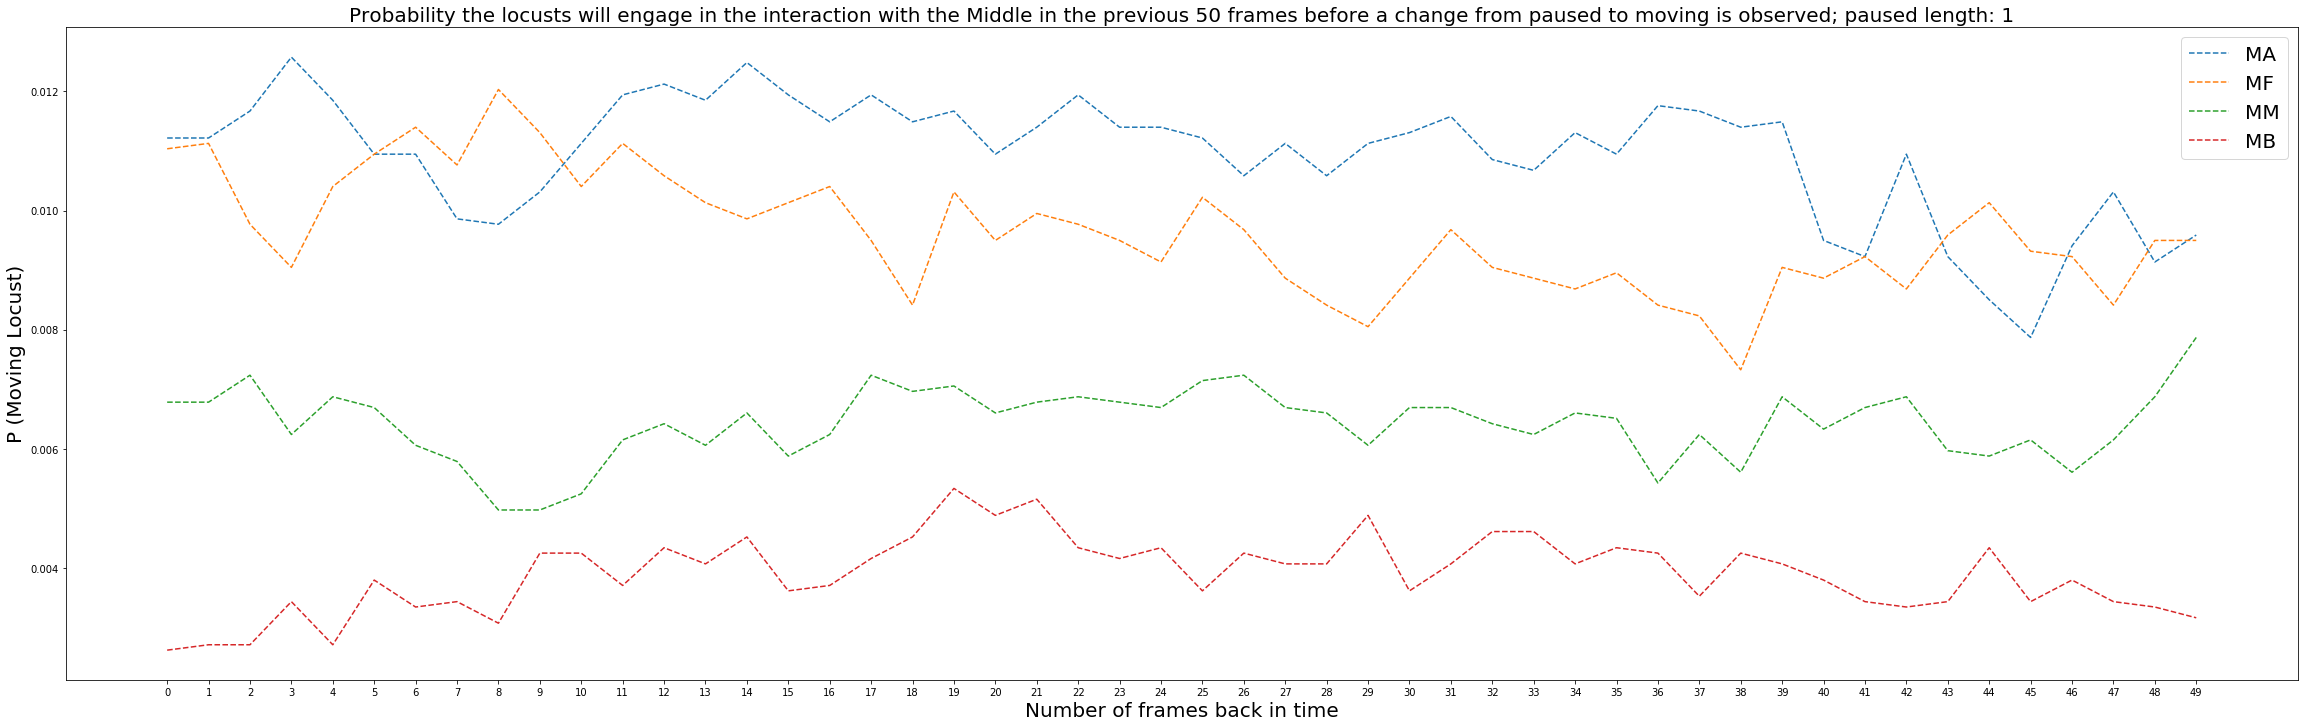

speed changes:  1843


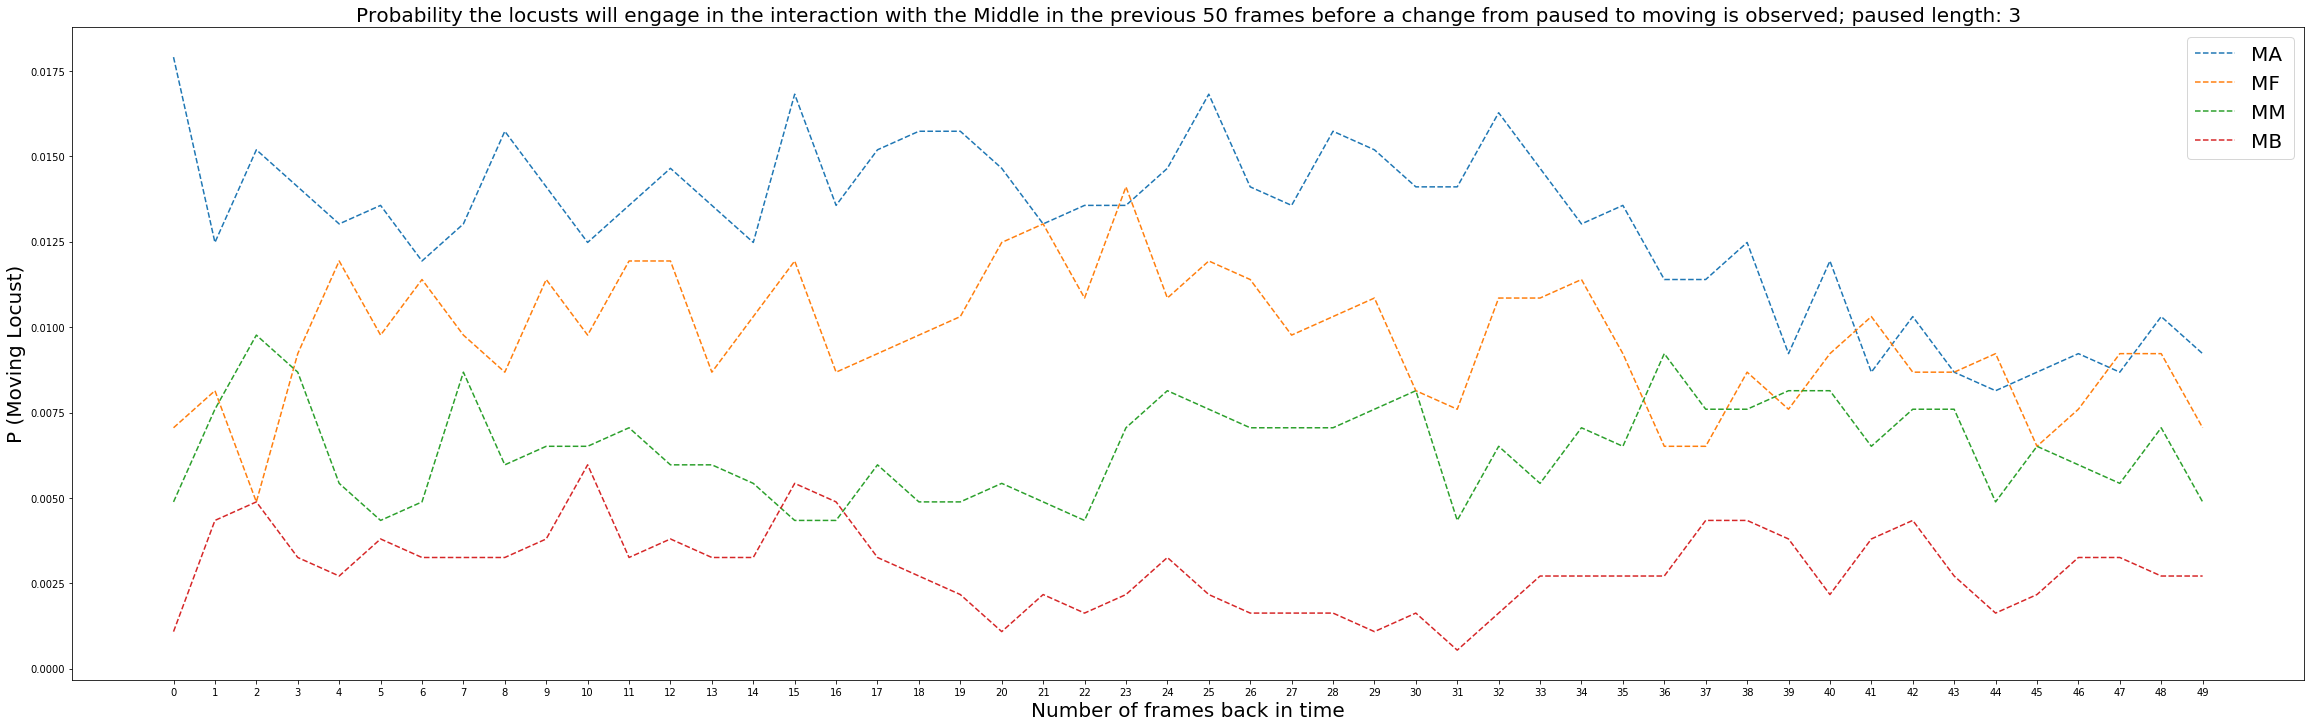

speed changes:  291


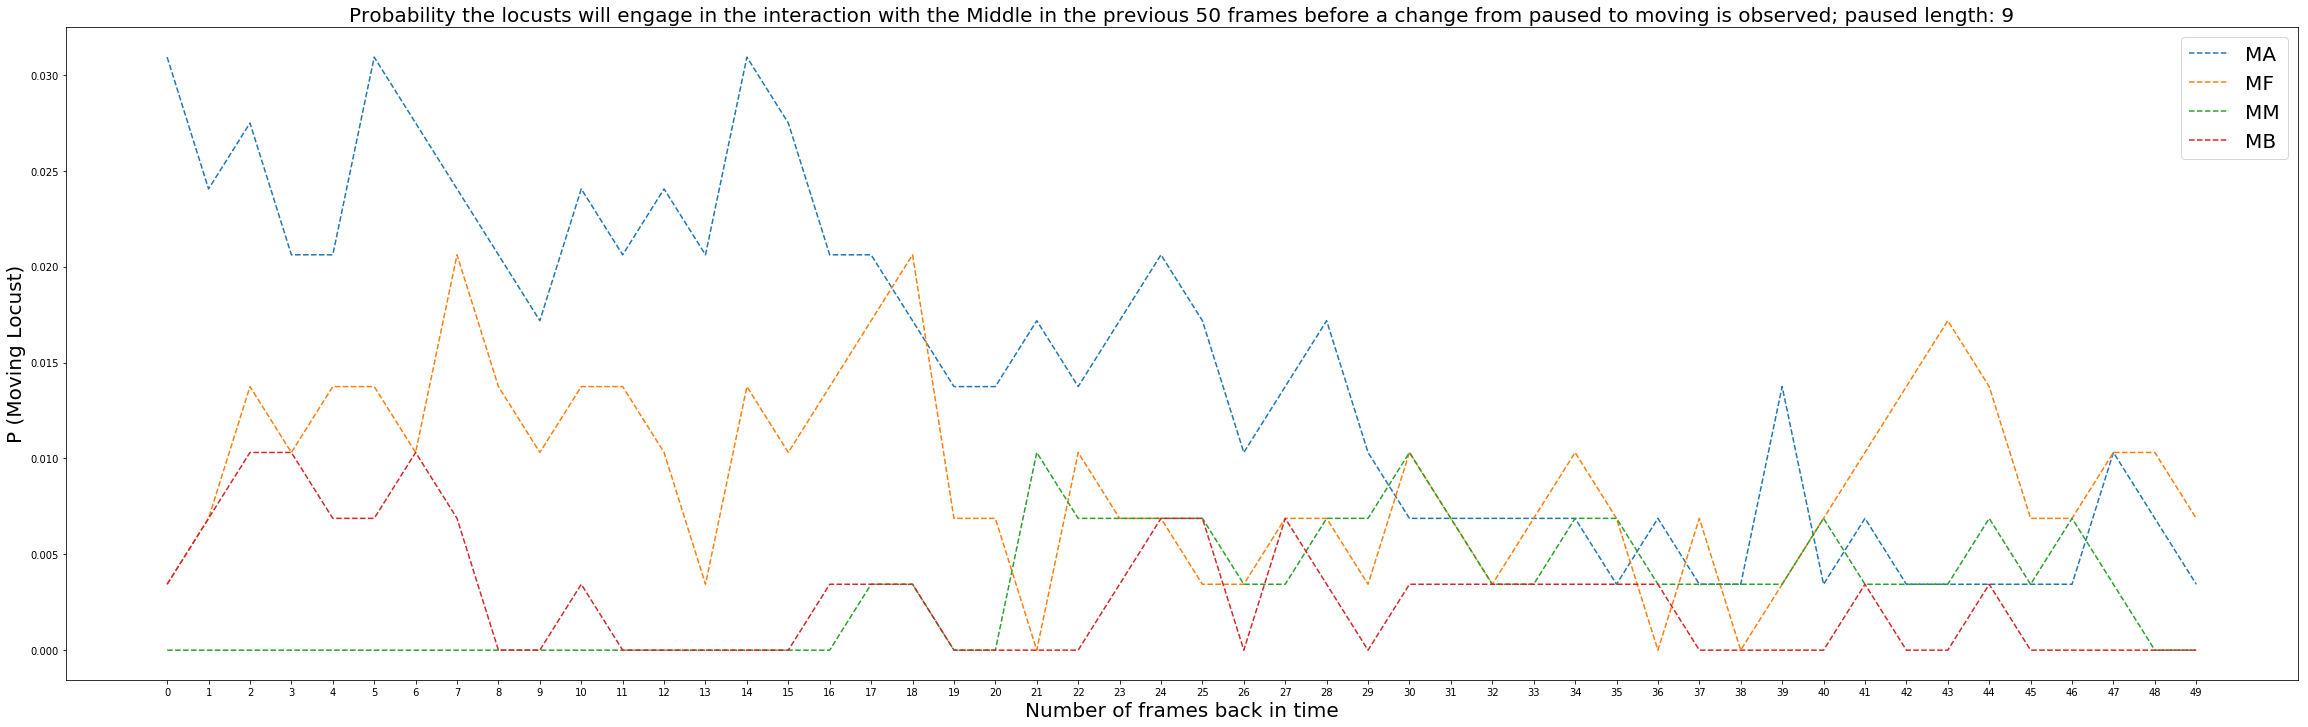

speed changes:  92


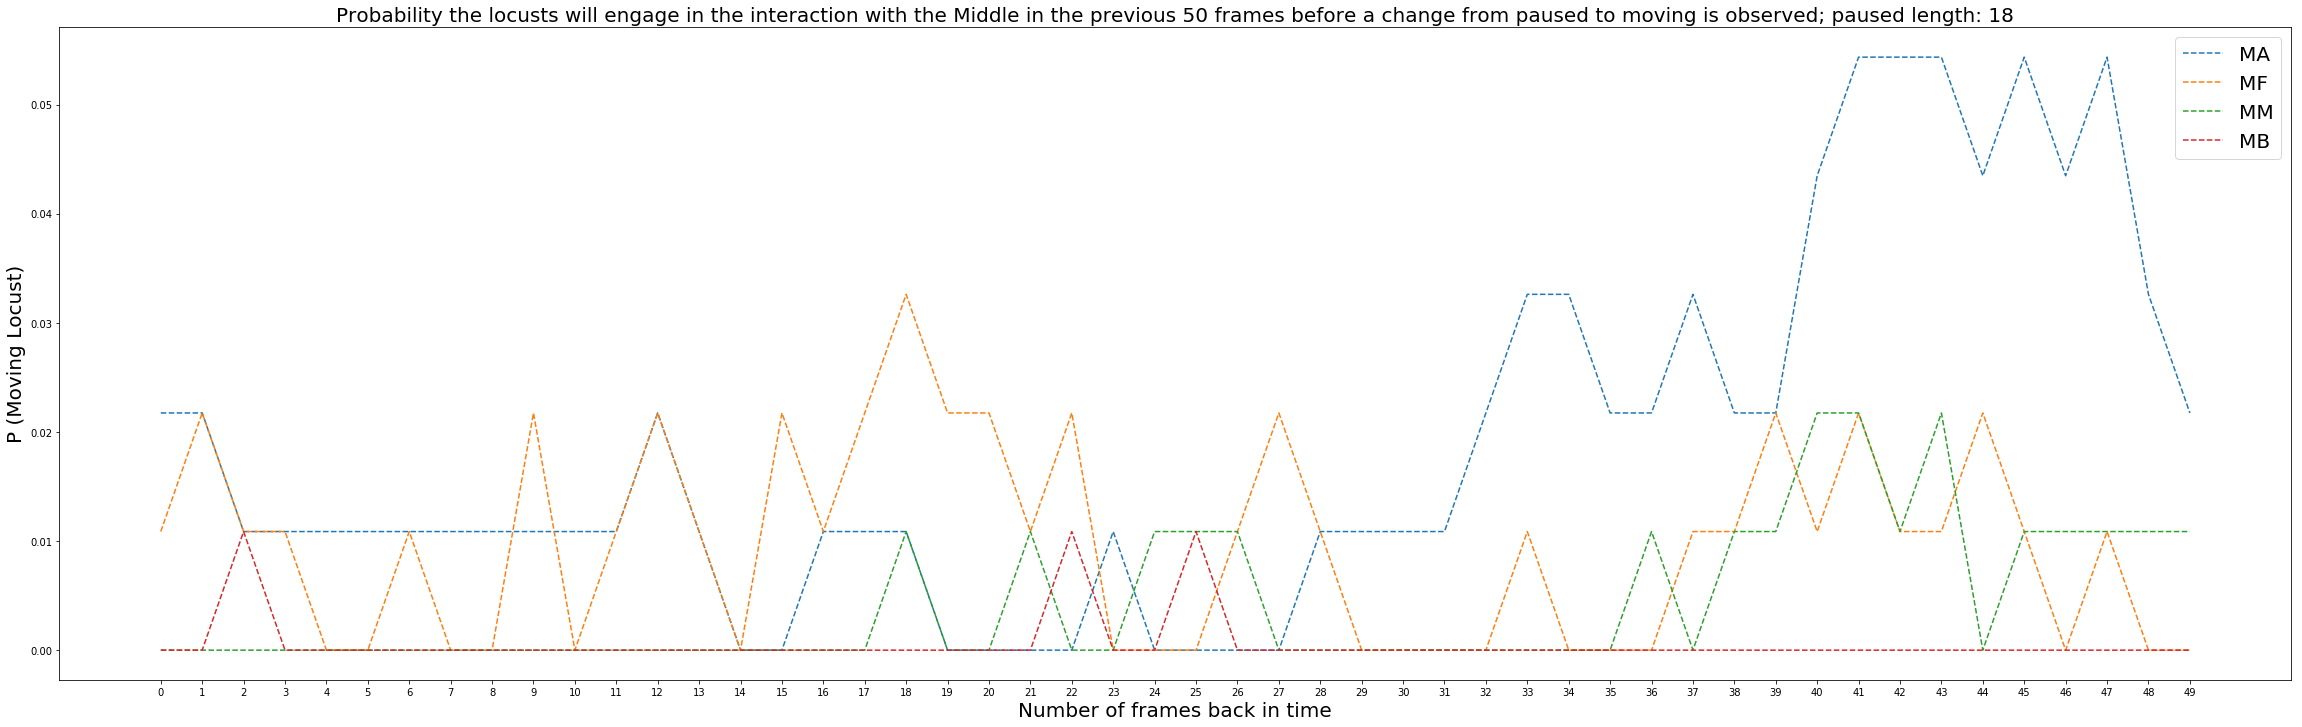

In [152]:
region = "Middle"
labels = ['MA', 'MF', 'MM', 'MB']

for pause_length in pause_lengths:
    history, sc = pairwise_history(pairwise_AFMB, framesback=framesback, pause_length=pause_length)
    plot_pairwise(region=region, A=history[AFMB_dict[labels[0]]]/sc, F=history[AFMB_dict[labels[1]]]/sc, M=history[AFMB_dict[labels[2]]]/sc, B=history[AFMB_dict[labels[3]]]/sc, 
                  framesback=framesback, labels=labels, pause_length=pause_length)

speed changes:  11055


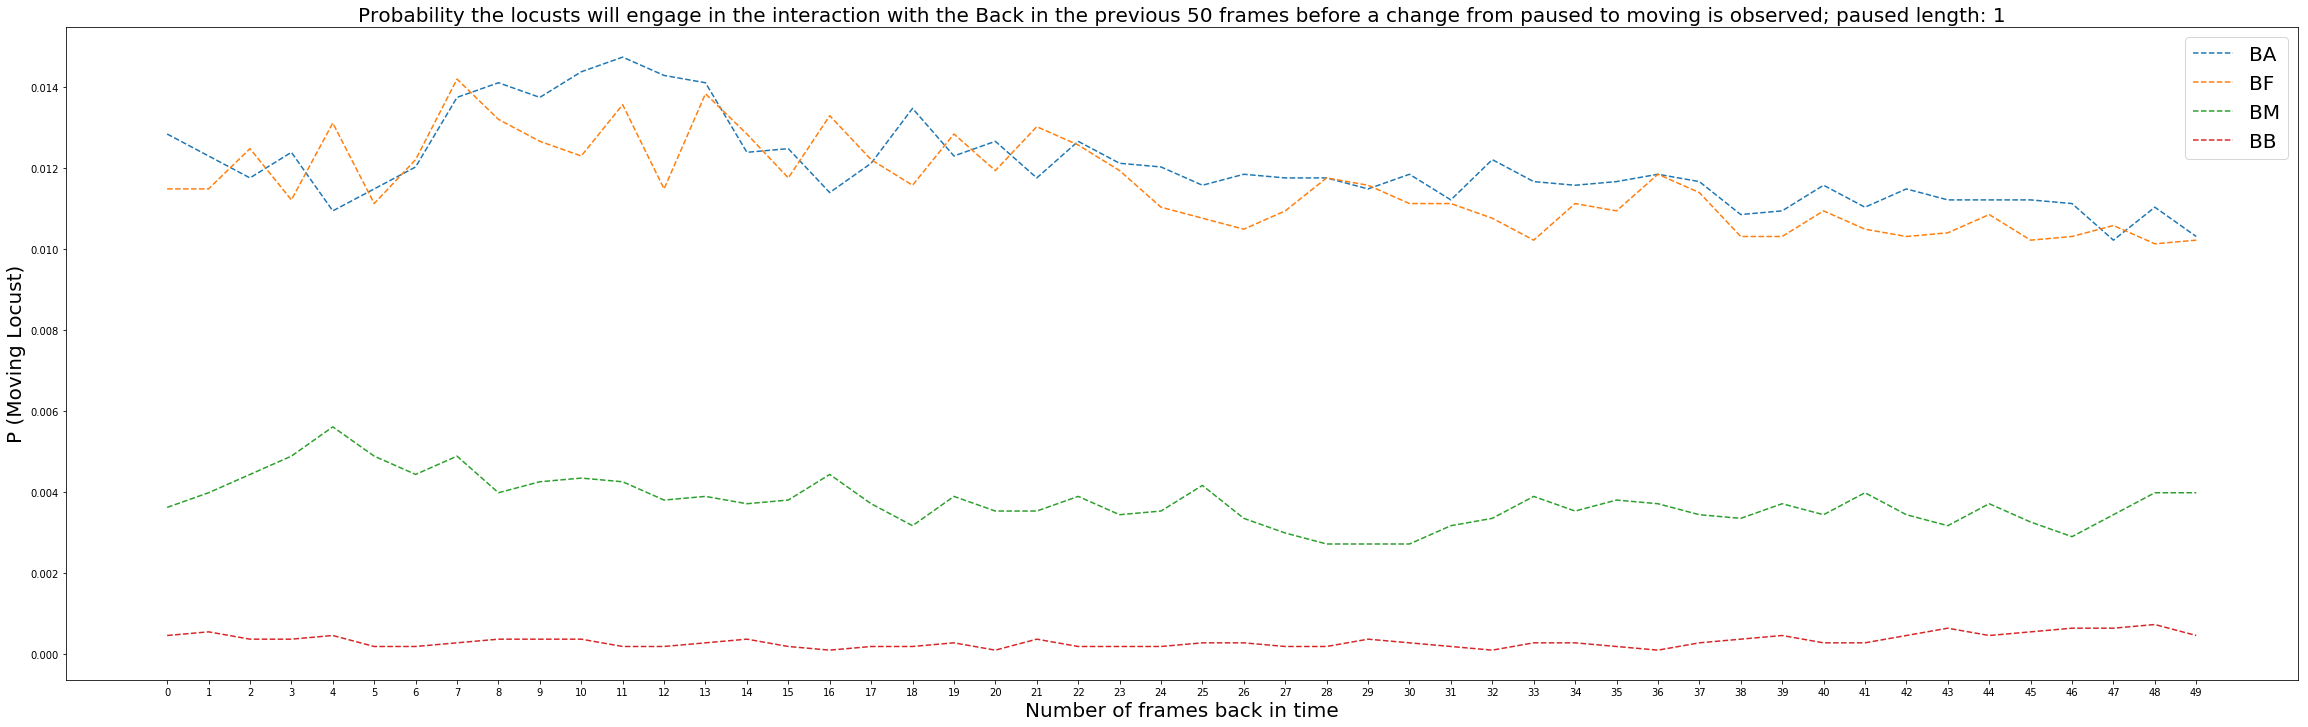

speed changes:  1843


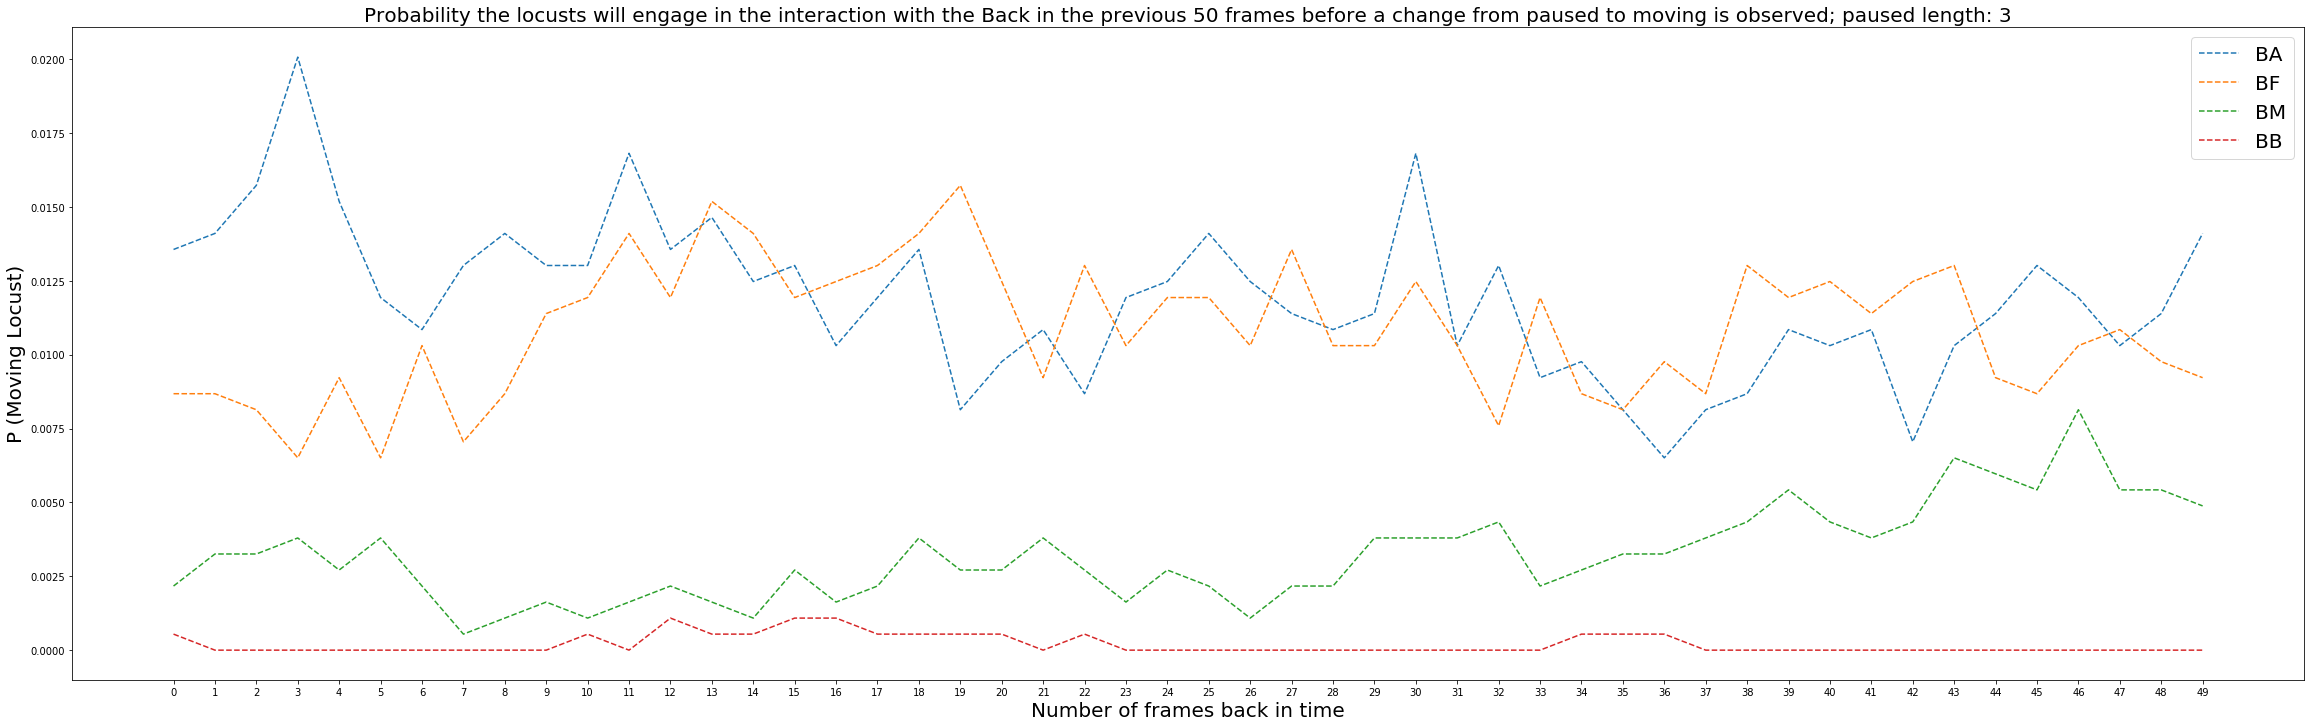

speed changes:  291


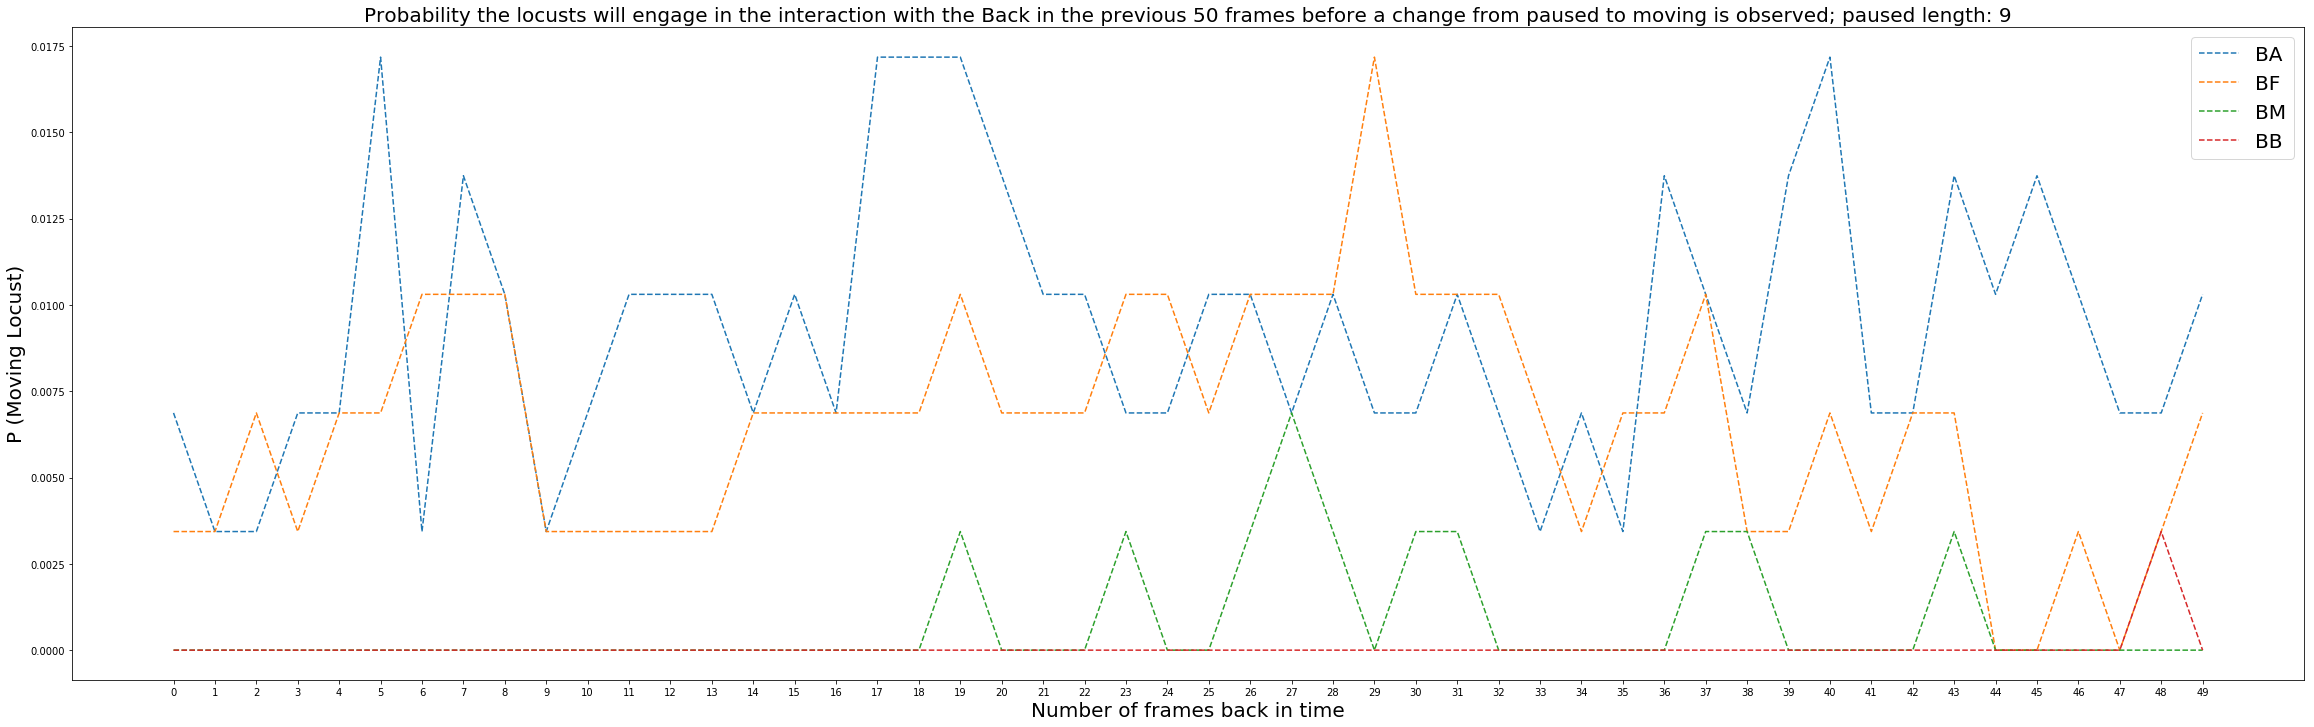

speed changes:  92


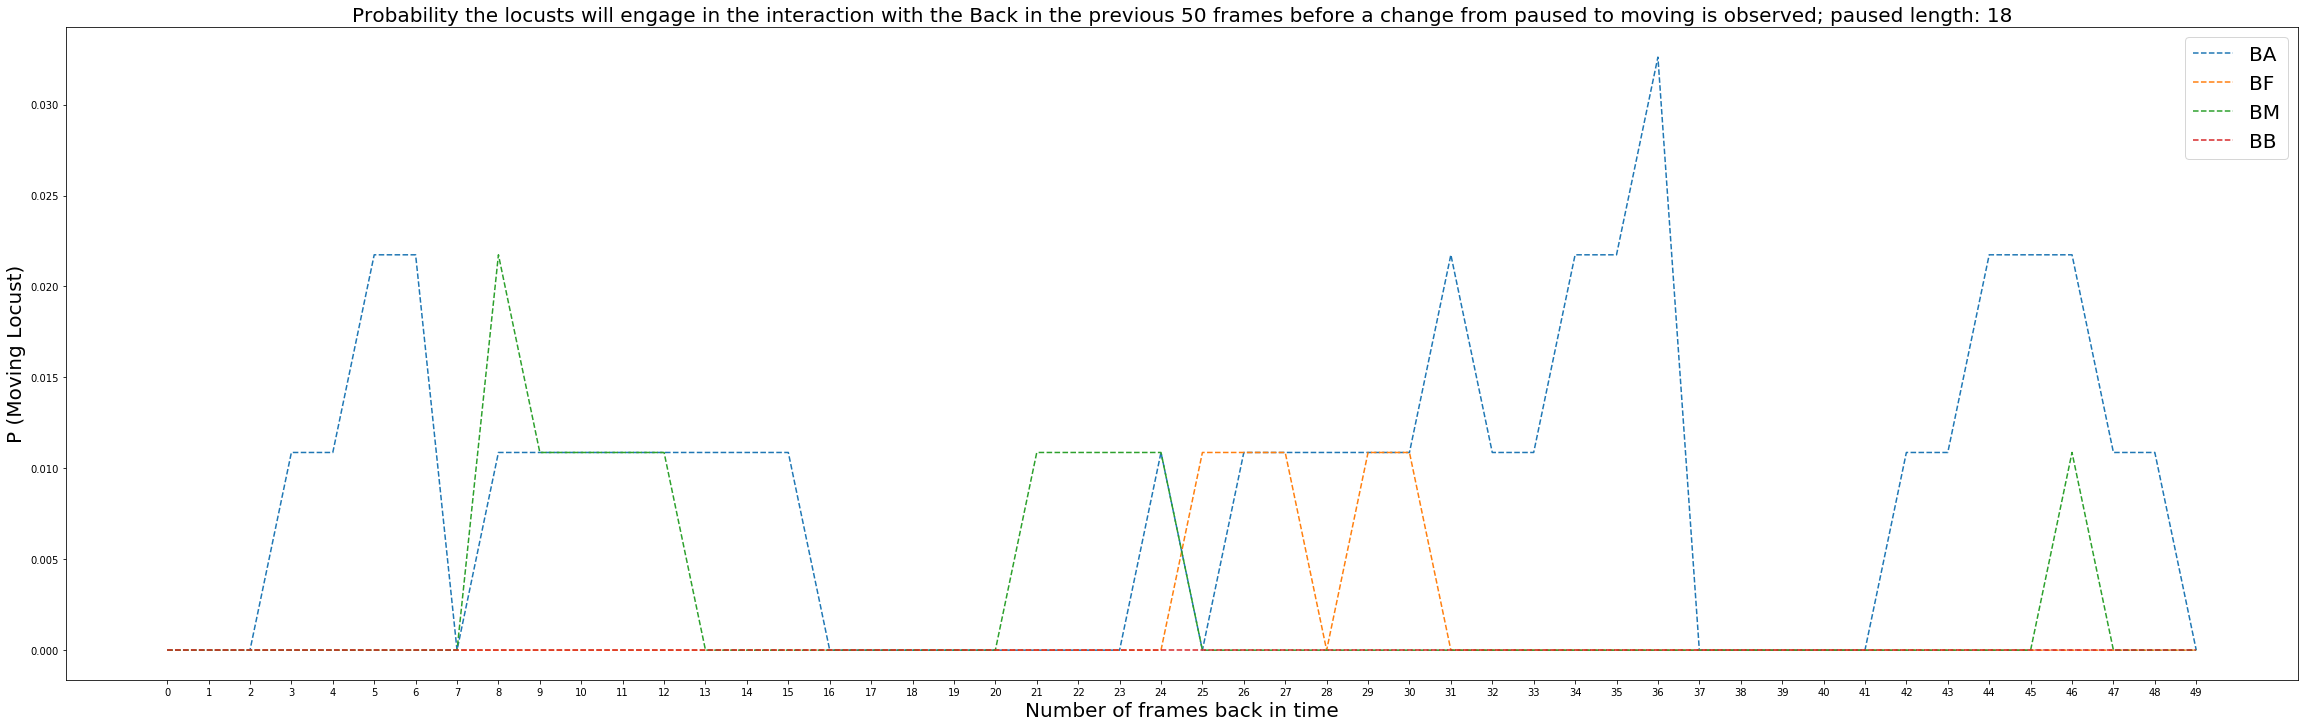

In [153]:
region = "Back"
labels = ['BA', 'BF', 'BM', 'BB']

for pause_length in pause_lengths:
    history, sc = pairwise_history(pairwise_AFMB, framesback=framesback, pause_length=pause_length)
    plot_pairwise(region=region, A=history[AFMB_dict[labels[0]]]/sc, F=history[AFMB_dict[labels[1]]]/sc, M=history[AFMB_dict[labels[2]]]/sc, B=history[AFMB_dict[labels[3]]]/sc, 
                  framesback=framesback, labels=labels, pause_length=pause_length)

#### Clustering
Given a time frame, what is the number of times Locusts have done each interaction in the past?
16 vector of interaction where each data point is a count for each type of interaction 

#### Pairwise Interaction Breakdown

In [146]:
unique, counts=np.unique(pairwise_AFMB, return_counts=True)
unique[0:18], counts[0:18]
# note: many interactions counted as "neither"

(array([-1.,  0.,  2.,  3.,  5.,  7., 11., 13., 17., 19., 23., 29., 31.,
        37., 41., 43., 47., 53.]),
 array([60438, 12489,  4309,  3204,  3626,  3813,  3229,  3784,  4271,
         4099,  3911,  4692,  3703,  1533,  3967,  4489,  1552,   156],
       dtype=int64))

In [170]:
k=np.insert(list(AFMB_dict.keys()), (0,1), ("no", "ia"))
# no = no unique intersection region, multiple limbs intersecting
# ia: intersecting with abdomen

In [171]:
count = dict(zip(k, counts[0:18]))

In [ ]:
count

### Speed of Front Legs

#### Generate Data for Speed of Forelegs

In [36]:
with h5py.File('forelegL_speed.h5', 'r') as h5File:
    forelegL_speed_h5 = h5File.get('speed')
    forelegL_speed_h5 = np.array(forelegL_speed_h5)

with h5py.File('forelegR_speed.h5', 'r') as h5File:
    forelegR_speed_h5 = h5File.get('speed')
    forelegR_speed_h5 = np.array(forelegR_speed_h5)

In [37]:
forelegL_speed=forelegL_speed_h5[:, 0:totalFrames]
forelegR_speed=forelegR_speed_h5[:, 0:totalFrames]

In [145]:
def get_speeds(pairwise_X, y, L_speed, R_speed, moving, touching, limbs): # add an argument so you can change what it's touching
    if moving: 
        moving_numb=1
    else: 
        moving_numb=0
            
    paused_touching_L=[]
    paused_touching_R=[]

    for locust in range(y.shape[0]):
        for frame in range(y.shape[1]):
            # if moving or paused
            if (y[locust, frame, 0]==moving_numb):
                num=pairwise_X[locust, frame, 0]
                if touching:
                    if (num==limbs[0] or num==limbs[1] or num==limbs[2] or num==limbs[3]):
                        paused_touching_L.append(L_speed[locust, frame])
                        paused_touching_R.append(R_speed[locust, frame])
                else: # if not touching
                    if not (num==limbs[0] or num==limbs[1] or num==limbs[2] or num==limbs[3]):
                        paused_touching_L.append(L_speed[locust, frame])
                        paused_touching_R.append(R_speed[locust, frame])
    return paused_touching_L, paused_touching_R

In [146]:
def graph_title(orientation, mode, limb):
    title=('Distribution of Speed of the %s %s when Locust is %s ' % (orientation, limb, mode))
    xlabel=('Speed of %s Front Legs' % orientation)
    location=('./plots/FL_Speed/%s_histo_%s.png' % (mode, orientation))
    return title, xlabel, location

In [147]:
pairwise_X.shape, y.shape, forelegR_speed.shape

((103, 6000, 1), (103, 6000, 1), (103, 6000))

### Front Legs Touching: Changing if Locust is Paused or Moving

#### Speed of Front Legs when Locust is Paused, Touching

In [ ]:
front=[11, 13, 17, 19]

In [154]:
# Speed of Front Legs when Locust is Paused, Touching
paused_left, paused_right = get_speeds(pairwise_X, y, forelegL_speed, forelegR_speed, 
                                                      moving=False, touching=True, limbs=front)
print("Median of Left Leg: %.8f Median of Right Leg: %.8f" % (np.median(paused_left), np.median(paused_right)))
print("Mean of Left Leg: %.8f Mean of Right Leg: %.8f" % (np.mean(paused_left), np.mean(paused_right)))

Median of Left Leg: 0.00025821 Median of Right Leg: 0.00032974
Mean of Left Leg: 0.00034944 Mean of Right Leg: 0.00066882


#### Speed of Front Legs when Locust is Moving, Touching

In [155]:
moving_left, moving_right = get_speeds(pairwise_X, y, forelegL_speed, forelegR_speed, 
                                                      moving=True, touching=True, limbs=front)
print("Median of Left Leg: %.8f Median of Right Leg: %.8f" % (np.median(moving_left), np.median(moving_right)))
print("Mean of Left Leg: %.8f Mean of Right Leg: %.8f" % (np.mean(moving_left), np.mean(moving_right)))

Median of Left Leg: 0.00263848 Median of Right Leg: 0.00249323
Mean of Left Leg: 0.00320789 Mean of Right Leg: 0.00330478


#### Histogram

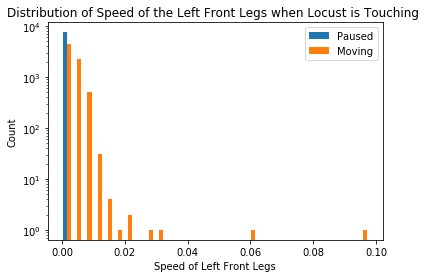

In [159]:
title, xlabel, location=graph_title('Left', 'Touching', 'Front Legs')
histo([paused_left, moving_left], title, xlabel, location, labels=["Paused", "Moving"], log=True)

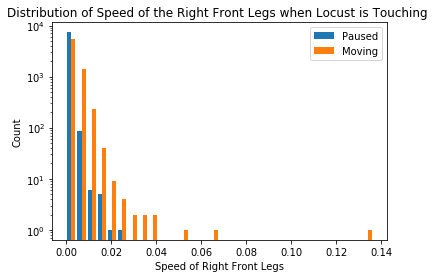

In [160]:
title, xlabel, location=graph_title('Right', 'Touching', 'Front Legs')
histo([paused_right, moving_right], title, xlabel, location, labels=["Paused", "Moving"], log=True)

### Front Legs Not Touching

#### Speed of Front Legs when Locust is Paused, Not Touching

In [161]:
# Speed of Front Legs when Locust is Paused, Not Touching
paused_left, paused_right = get_speeds(pairwise_X, y, forelegL_speed, forelegR_speed, 
                                                      moving=False, touching=False, limbs=front)
print("Median of Left Leg: %.8f Median of Right Leg: %.8f" % (np.median(paused_left), np.median(paused_right)))
print("Mean of Left Leg: %.8f Mean of Right Leg: %.8f" % (np.mean(paused_left), np.mean(paused_right)))

Median of Left Leg: 0.00022424 Median of Right Leg: 0.00033110
Mean of Left Leg: 0.00030870 Mean of Right Leg: 0.00076404


#### Speed of Front Legs when Locust is Moving, Touching

In [163]:
moving_left, moving_right = get_speeds(pairwise_X, y, forelegL_speed, forelegR_speed, 
                                                      moving=True, touching=False, limbs=front)
print("Median of Left Leg: %.8f Median of Right Leg: %.8f" % (np.median(moving_left), np.median(moving_right)))
print("Mean of Left Leg: %.8f Mean of Right Leg: %.8f" % (np.mean(moving_left), np.mean(moving_right)))

Median of Left Leg: 0.00412505 Median of Right Leg: 0.00400304
Mean of Left Leg: 0.00440644 Mean of Right Leg: 0.00469452


#### Histogram

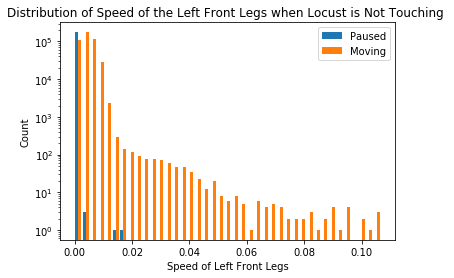

In [164]:
title, xlabel, location=graph_title('Left', 'Not Touching', 'Front Legs')
histo([paused_left, moving_left], title, xlabel, location, labels=["Paused", "Moving"], log=True)

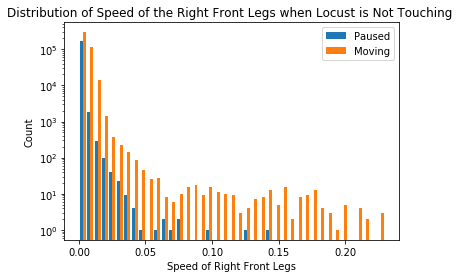

In [165]:
title, xlabel, location=graph_title('Right', 'Not Touching', 'Front Legs')
histo([paused_right, moving_right], title, xlabel, location, labels=["Paused", "Moving"], log=True)

## Antenna

In [36]:
with h5py.File('antL_speed.h5', 'r') as h5File:
    antL_speed_h5 = h5File.get('speed')
    antL_speed_h5 = np.array(antL_speed_h5)

with h5py.File('antR_speed.h5', 'r') as h5File:
    antR_speed_h5 = h5File.get('speed')
    antR_speed_h5 = np.array(antR_speed_h5)

In [37]:
antL_speed=antL_speed_h5[:, 0:totalFrames]
antR_speed=antR_speed_h5[:, 0:totalFrames]

In [147]:
pairwise_X.shape, y.shape, antR_speed.shape

((103, 6000, 1), (103, 6000, 1), (103, 6000))

### Antenna Touching: Changing if Locust is Paused or Moving

#### Speed of Antenna when Locust is Paused, Touching

In [ ]:
ant=[2,3,5,7]

In [154]:
# Speed of Front Legs when Locust is Paused, Touching
paused_left, paused_right = get_speeds(pairwise_X, y, antL_speed, antR_speed, 
                                                      moving=False, touching=True, limbs=ant)
print("Median of Left Ant: %.8f Median of Right Ant: %.8f" % (np.median(paused_left), np.median(paused_right)))
print("Mean of Left Ant: %.8f Mean of Right Ant: %.8f" % (np.mean(paused_left), np.mean(paused_right)))

Median of Left Leg: 0.00025821 Median of Right Leg: 0.00032974
Mean of Left Leg: 0.00034944 Mean of Right Leg: 0.00066882


#### Speed of Antenna when Locust is Moving, Touching

In [155]:
moving_left, moving_right = get_speeds(pairwise_X, y, antL_speed, antR_speed, 
                                                      moving=True, touching=True, limbs=ant)
print("Median of Left Ant: %.8f Median of Right Ant: %.8f" % (np.median(moving_left), np.median(moving_right)))
print("Mean of Left Ant: %.8f Mean of Right Ant: %.8f" % (np.mean(moving_left), np.mean(moving_right)))

Median of Left Leg: 0.00263848 Median of Right Leg: 0.00249323
Mean of Left Leg: 0.00320789 Mean of Right Leg: 0.00330478


#### Histogram

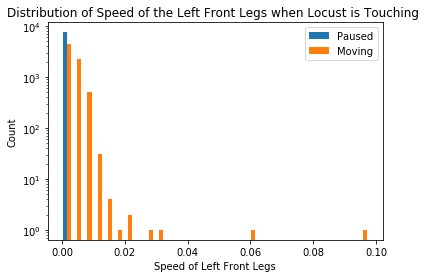

In [159]:
title, xlabel, location=graph_title('Left', 'Touching', 'Antenna')
histo([paused_left, moving_left], title, xlabel, location, labels=["Paused", "Moving"], log=True)

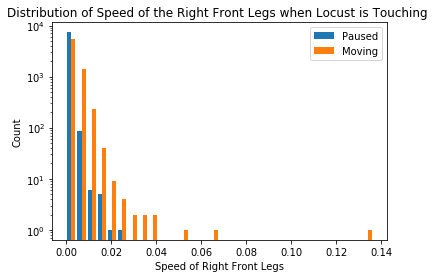

In [160]:
title, xlabel, location=graph_title('Right', 'Touching', 'Antenna')
histo([paused_right, moving_right], title, xlabel, location, labels=["Paused", "Moving"], log=True)

### Antenna Not Touching

#### Speed of Antenna when Locust is Paused, Not Touching

In [161]:
# Speed of Ant when Locust is Paused, Not Touching
paused_left, paused_right = get_speeds(pairwise_X, y, antL_speed, antR_speed, 
                                                      moving=False, touching=False, limbs=ant)
print("Median of Left Ant: %.8f Median of Right Ant: %.8f" % (np.median(paused_left), np.median(paused_right)))
print("Mean of Left Ant: %.8f Mean of Right Ant: %.8f" % (np.mean(paused_left), np.mean(paused_right)))

Median of Left Leg: 0.00022424 Median of Right Leg: 0.00033110
Mean of Left Leg: 0.00030870 Mean of Right Leg: 0.00076404


#### Speed of Antenna when Locust is Moving, Touching

In [163]:
moving_left, moving_right = get_speeds(pairwise_X, y, antL_speed, antR_speed, 
                                                      moving=True, touching=False, limbs=ant)
print("Median of Left Ant: %.8f Median of Right Ant: %.8f" % (np.median(moving_left), np.median(moving_right)))
print("Mean of Left Ant: %.8f Mean of Right Ant: %.8f" % (np.mean(moving_left), np.mean(moving_right)))

Median of Left Leg: 0.00412505 Median of Right Leg: 0.00400304
Mean of Left Leg: 0.00440644 Mean of Right Leg: 0.00469452


#### Histogram

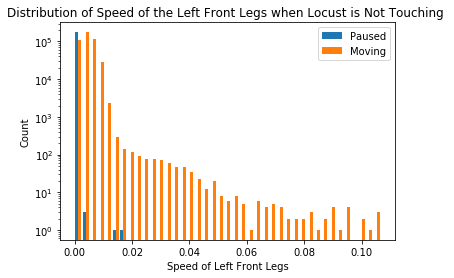

In [164]:
title, xlabel, location=graph_title('Left', 'Not Touching', 'Antenna')
histo([paused_left, moving_left], title, xlabel, location, labels=["Paused", "Moving"], log=True)

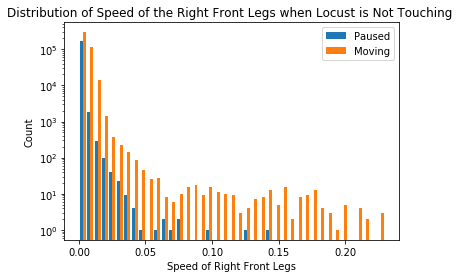

In [165]:
title, xlabel, location=graph_title('Right', 'Not Touching', 'Antenna')
histo([paused_right, moving_right], title, xlabel, location, labels=["Paused", "Moving"], log=True)